# pyEDMを使った生態学時系列データの因果推定
---
[pyEDM](https://github.com/SugiharaLab/pyEDM) で生態学時系列データのEmpirical Dynamic Modeling (EDM) をやってみる。  
<br/>
EDMは、時系列データを非線形力学系としてモデリングして、変数間の相互作用推定や未来予測などをする一連の手法。モデリングといっても、なんらかの数式を仮定するんじゃなくて、時系列の観測値のみから系の状態空間を再構成して Model-free (equation-free) に挙動を解析する。  
<br/>
相関係数では検出できない変数間の「因果」の方向性を検出するConvergent Cross Mapping 法 (CCM) がとくに有名。手法の提案論文（[Sugihara, et al. "Detecting causality in complex ecosystems." Science (2012)](https://science.sciencemag.org/content/338/6106/496)）で詳細に説明されている。著者らが公開してる手法の[説明動画](https://www.youtube.com/watch?v=NrFdIz-D2yM)もわかりやすい?かも。日本語の総説だと[この文献](https://www.jstage.jst.go.jp/article/seitai/65/3/65_KJ00010198786/_pdf)がすごくわかりやすい（CCMが検出する「因果」とはなにか、広く使われている「Granger因果」とどのように異なるのか、など解説してくれてる）。  
EDM全体の概説は[Empirical dynamic modeling for beginners](https://link.springer.com/article/10.1007/s11284-017-1469-9)が読みやすくてオススメ。  
<br/>
ここで扱うデータは、[Ushio, M. et al.Nature (2018)](https://www.nature.com/articles/nature25504).  
舞鶴湾で収集した海水魚群集の12年間分のカウントデータを著者が公開してくれているので、それを使って、ほぼ論文のメソッドにしたがって（ただしrEDMではなくpyEDMで）解析してみる。カウントテーブルから出発して、論文の主要な結果（の一部）の再現にトライしてみる。具体的には以下の図（[JSTのプレスリリース](https://www.jst.go.jp/pr/announce/20180208/index.html)より）で表現されている種間の「因果」関係（魚Aの存在量は魚Bの存在量にpositive/negativeに寄与している、とか、逆方向の因果は無い、とか）を計算してみる。    
<br/>
<img src="https://www.jst.go.jp/pr/announce/20180208/icons/zu1.jpg" width="300">
<br/>
EDMの理論そのものはそれほど深く理解できてるわけじゃないので間違いがあったらすみません。

In [20]:
%%bash
#git clone https://github.com/SugiharaLab/pyEDM
#cd pyEDM/cppEDM/src; make
#cd ../..; python -m pip install . --user --trusted-host pypi.org

pyEDMをダウンロード、インストールする。  
Rユーザは[rEDM](https://github.com/ha0ye/rEDM)使った方がいいと思う。使い方を丁寧に解説してくれている先生もいる<https://sites.google.com/site/dkyogoku/redm-no-shii-fang>  
pyEDMはcppEDMのラッパースクリプトなんだけど、まだ日が浅くてわりと頻繁に更新されてるので注意。  
一応ここで使っているバージョンは↓のような感じ。

In [21]:
!pip show pyEDM

Name: pyEDM
Version: 1.0.1
Summary: Python wrapper for cppEDM using pybind11
Home-page: https://github.com/SugiharaLab/pyEDM
Author: Joseph Park & Cameron Smith
Author-email: Sugihara.Lab@gmail.com
License: Copyright 2019 The Regents of the University of California.
Location: /Users/higashi/.local/lib/python3.7/site-packages
Requires: matplotlib, pybind11, pandas
Required-by: 


In [22]:
import pyEDM

# データの読み込み
---
まずは論文のデータをダウンロードする。githubでデータと解析に使ったRスクリプトを公開してくれている。

In [23]:
#!wget https://raw.githubusercontent.com/ong8181/dynamic-stability/v1.0.0/data/Maizuru_dominant_sp.csv

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('./Maizuru_dominant_sp.csv', index_col=0)
df

surf.t  bot.t  Aurelia.sp  Engraulis.japonicus  \
date_tag                                                       
2002-6-early    22.0   19.0   79.200000                    0   
2002-6-late     21.0   21.0  157.200000                    0   
2002-7-early    25.0   22.0   21.333333                    0   
2002-7-late     30.0   24.0    0.937500                    0   
2002-8-early    28.0   25.0   19.333333                    0   
...              ...    ...         ...                  ...   
2014-2-early     5.4    8.5    0.000000                  150   
2014-2-late      5.5   10.4    0.000000                    1   
2014-3-early     8.4   10.5    0.000000                    0   
2014-3-late     11.5   10.4    0.250000                    0   
2014-4-early    15.4   10.5    0.666667                    0   

              Plotosus.lineatus  Sebastes.inermis  Trachurus.japonicus  \
date_tag                                                                 
2002-6-early                  1               463                    0   
2002-6-late                   0                19                  650   
2002-7-early                300                47                 1150   
2002-7-late                 302                46                  958   
2002-8-early                540                43                  308   
...                         ...               ...                  ...   
2014-2-early                  0                 1                    0   
2014-2-late                   0                 0                    0   
2014-3-early                  0                 0                    0   
2014-3-late                   0                 0                    0   
2014-4-early                  0                 0                    0   

              Girella.punctata  Pseudolabrus.sieboldi  \
date_tag                                                
2002-6-early                60                     18   
2002-6-late                 42                     22   
2002-7-early                 8                      7   
2002-7-late                 34                     19   
2002-8-early                15                     14   
...                        ...                    ...   
2014-2-early                 0                      0   
2014-2-late                  0                      0   
2014-3-early                 0                      0   
2014-3-late                  0                      0   
2014-4-early                 0                      1   

              Halichoeres.poecilopterus  Halichoeres.tenuispinnis  \
date_tag                                                            
2002-6-early                         31                        23   
2002-6-late                          10                        23   
2002-7-early                          7                        32   
2002-7-late                          30                        22   
2002-8-early                         10                        16   
...                                 ...                       ...   
2014-2-early                          0                         0   
2014-2-late                           0                         0   
2014-3-early                          0                         0   
2014-3-late                           0                         0   
2014-4-early                          0                         0   

              Chaenogobius.gulosus  Pterogobius.zonoleucus  \
date_tag                                                     
2002-6-early                 470.0                     0.0   
2002-6-late                    0.0                     0.0   
2002-7-early                   0.0                    50.0   
2002-7-late                   80.0                     6.0   
2002-8-early                   0.0                    50.0   
...                            ...                     ...   
2014-2-early                   0.0                     0.0   
2014-2-late         

こんな感じで、2002年から2014年まで隔週で、15種の魚（+クラゲ）が何匹観測されたかを記録したテーブルとなっている。  
まずは種のカウント以外のデータ（温度や日付など）のカラムを除去する。

In [26]:
Species = df.drop(['surf.t', 'bot.t', 'Y', 'M', 'D'], axis=1)

変数の変動のスケールを合わせるために、平均ゼロ、分散１に標準化する。  
ここ、EDMで結構重要な部分で、結果に大きく影響する。  
時系列にトレンドなどが含まれてしまっている場合はほとんどのEDMの手法がうまく働かないので、一階差分とるなどの操作が事前に必要。

In [27]:
from sklearn.preprocessing import StandardScaler
data = Species.values
scaler = StandardScaler(with_mean=True, with_std=True)
data = scaler.fit_transform(data)
print(data.mean(axis=0))
print(data.std(axis=0))

[-2.41522202e-17  6.23283102e-18 -2.49313241e-17 -3.11641551e-17
 -7.47939722e-17 -6.23283102e-18  6.23283102e-17 -2.49313241e-17
  0.00000000e+00  1.24656620e-17  0.00000000e+00  0.00000000e+00
 -6.23283102e-18  1.86984930e-17  3.73969861e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


とりあえずそれぞれの種がどんな変動をしているのか、2002年から2014年までのダイナミクスを描画してみる。

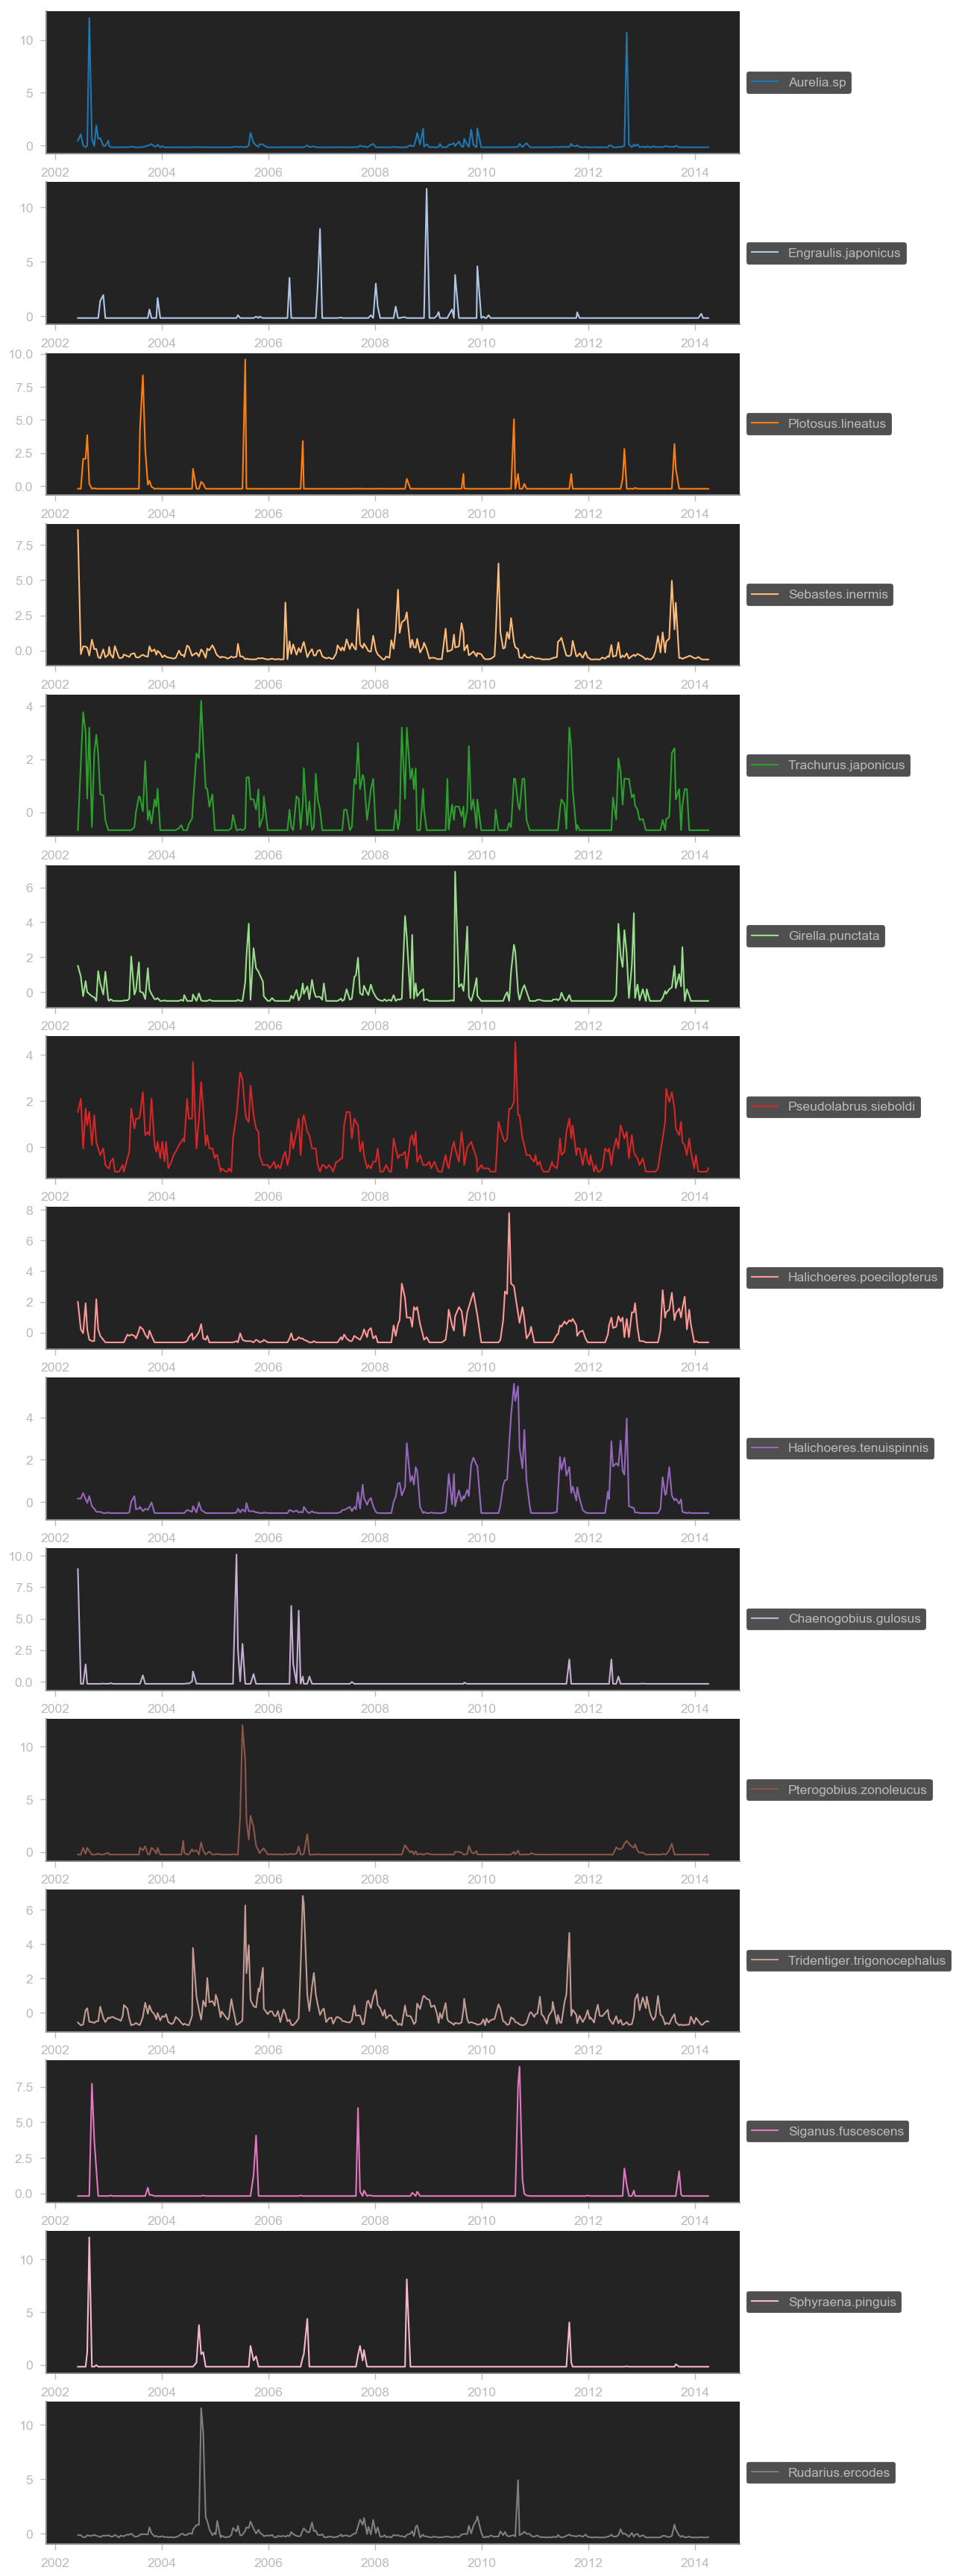

In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# 20個分のカラーセットを用意。
colors = [matplotlib.colors.rgb2hex(x) for x in cm.tab20.colors]

# テーブル中の年（Y）、月（M）、日（D）の情報からdatetime型のベクトルを作ってテーブルのインデックスにする。
datetime_index = pd.to_datetime(df['Y'].apply(str) + '-' + df['M'].apply(str) + '-' + df['D'].apply(str))
edm_data = pd.DataFrame(data, index=datetime_index, columns=Species.columns)

# pyEDMは仕様上なぜか、読み込ませるデータフレームの1列目をTime列にする必要がある
# 単にインデックスとして使うだけなので適当に設定しておく
edm_data.insert(loc=0, column='Time', value=range(len(edm_data)))

fig = plt.figure(figsize=(12,45))
for i, label in enumerate(edm_data.columns[1:]):
    ax = fig.add_subplot(len(edm_data.columns[1:]), 1, i+1)
    ax.plot(edm_data.index, edm_data[label], c=colors[i], label=label)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.show()

# 埋め込み次元の決定
---
EDM全体をつらぬく前提は、複雑に変動する非線形力学系の挙動の解析や予測に重要なのは、データ点間の時間的な近さではなく、  
時系列データを**時間遅れ座標の状態空間**に埋め込んだときの、その空間内におけるデータ点間の近さ、という考え方。
  
埋め込みっていうのはそれほど複雑な話ではなくて、たとえばある時系列 X(1), X(2), ..., X(t-1), X(t), ...を二次元に埋め込む場合は、x(t) = (X(t), X(t-1))でそれぞれの点の座標をとった状態空間に、三次元に埋め込む場合は x(t) = (X(t), X(t-1), X(t-2)) という座標に、といった感じ。  
[Takens' theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem)によれば、非線形決定論的力学系に従う系のアトラクタと接空間の構造は、すべての変数が観測できなくても、一変数の時間遅れ状態空間の構造に保存されている、ということらしい（時間遅れ状態空間が「埋め込み」である＝アトラクタと時間遅れ多様体に滑らかな一対一の対応関係がある）。そのため力学系全体の幾何学的構造を反映する情報が、一変数のみの時間遅れ埋め込みの構造から得られる。  
<br/>
この時間遅れの状態空間への埋め込みは`pyEDM`の`Embed`関数で簡単に実行できる。(E個ずつずらしてベクトルにするだけなので自分でも簡単に書けるけど)

In [29]:
# 前項で作った15種全体のデータフレーム edm_data から２種抜き出して二次元(E=2)に埋め込み
embed = pyEDM.Embed(dataFrame=edm_data, E=2, columns='Aurelia.sp, Engraulis.japonicus')
embed

Aurelia.sp(t-0)  Aurelia.sp(t-1)  Engraulis.japonicus(t-0)  \
0           1.059990         0.440083                 -0.179740   
1          -0.019813         1.059990                 -0.179740   
2          -0.181910        -0.019813                 -0.179740   
3          -0.035708        -0.181910                 -0.179740   
4          12.079631        -0.035708                 -0.179740   
..               ...              ...                       ...   
279        -0.189361        -0.189361                  0.216419   
280        -0.189361        -0.189361                 -0.177099   
281        -0.189361        -0.189361                 -0.179740   
282        -0.187374        -0.189361                 -0.179740   
283        -0.184062        -0.187374                 -0.179740   

     Engraulis.japonicus(t-1)  
0                   -0.179740  
1                   -0.179740  
2                   -0.179740  
3                   -0.179740  
4                   -0.179740  
..                        ...  
279                 -0.179740  
280                  0.216419  
281                 -0.177099  
282                 -0.179740  
283                 -0.179740  

[284 rows x 4 columns]

それでは実際に、何次元の（=何ステップ前までの）時間遅れ状態空間を構成すればいいのか。  
これは力学系の性質によって異なるので、事前に知るすべはない。  
<br/>
ここでは、観測データのみを使ってダイナミクスを支配している埋め込みを推定するために、それぞれの変数について、いろんな次元数で状態空間を構成して自分自身の未来を予測させる。その予測の精度がもっとも高くなる次元を、その変数の埋め込みとする。  
具体的にはSimplex projectionと呼ばれる手法を使う。E次元で構成した状態空間内のデータ点x(t+1)を予測する場合、まず状態空間内でx(t)のE+1個のnearest neighborの点を計算する。たとえば二次元状態空間の場合、x(t)との最近傍3点 x(t_a), x(t_b), x(t_c)と、それらとの距離を割り出す。t, t_a, t_b, t_cは時間的には全然近くない可能性があることに注意。その３点を使って、x(t_a + 1), x(t_b + 1), x(t_c + 1)の3点の位置を探して、それらの点を距離で重み付けした平均をとってx(t+1)の予測とする。  
<br/>
`pyEDM`では、`EmbedDimension`関数でやってくれる。内部的には指定した範囲のEでそれぞれ`Simplex`関数を呼び出して予測値と観測値の相関を計算し、図を出力している。

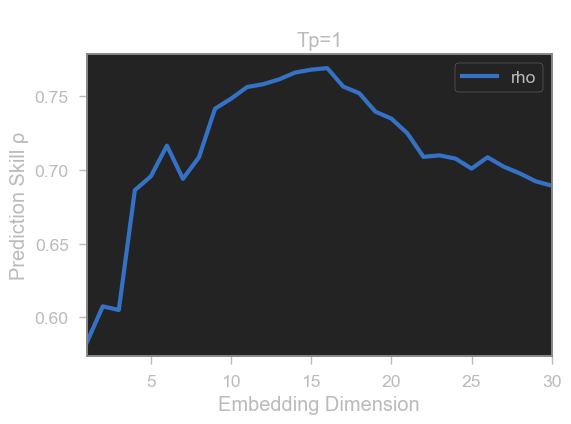

In [30]:
target = 'Halichoeres.poecilopterus'
RHOs = pyEDM.EmbedDimension(dataFrame = edm_data, \
                lib = "1 250", pred = "1 250", maxE=30, \
                columns = target, target = target) 

この場合、Halichoeres.poecilopterusの時系列データは16次元の埋め込み x(t) = (X(t), X(t-1), ..., X(t-15)) でもっとも予測精度が高くなることがわかった。  
大きければ大きいほどいいってわけでもなく、不必要な過去の情報が含まれると予測に重要な「近傍」が探せなくなってしまうので、ちょうどいいEを決める必要があるらしい。  
<br/>
ただ`EmbedDimension`関数は相関係数による比較のみっぽいので、論文で書かれてるようにmean absolute errorで予測精度測る場合は自分で計算しなきゃダメっぽい。  
隔週で観測されたデータなので、一年あたりのデータ点の数は24。一年前までダイナミクスに影響する可能性があると考えて、Eを2次元から24次元までテストする。

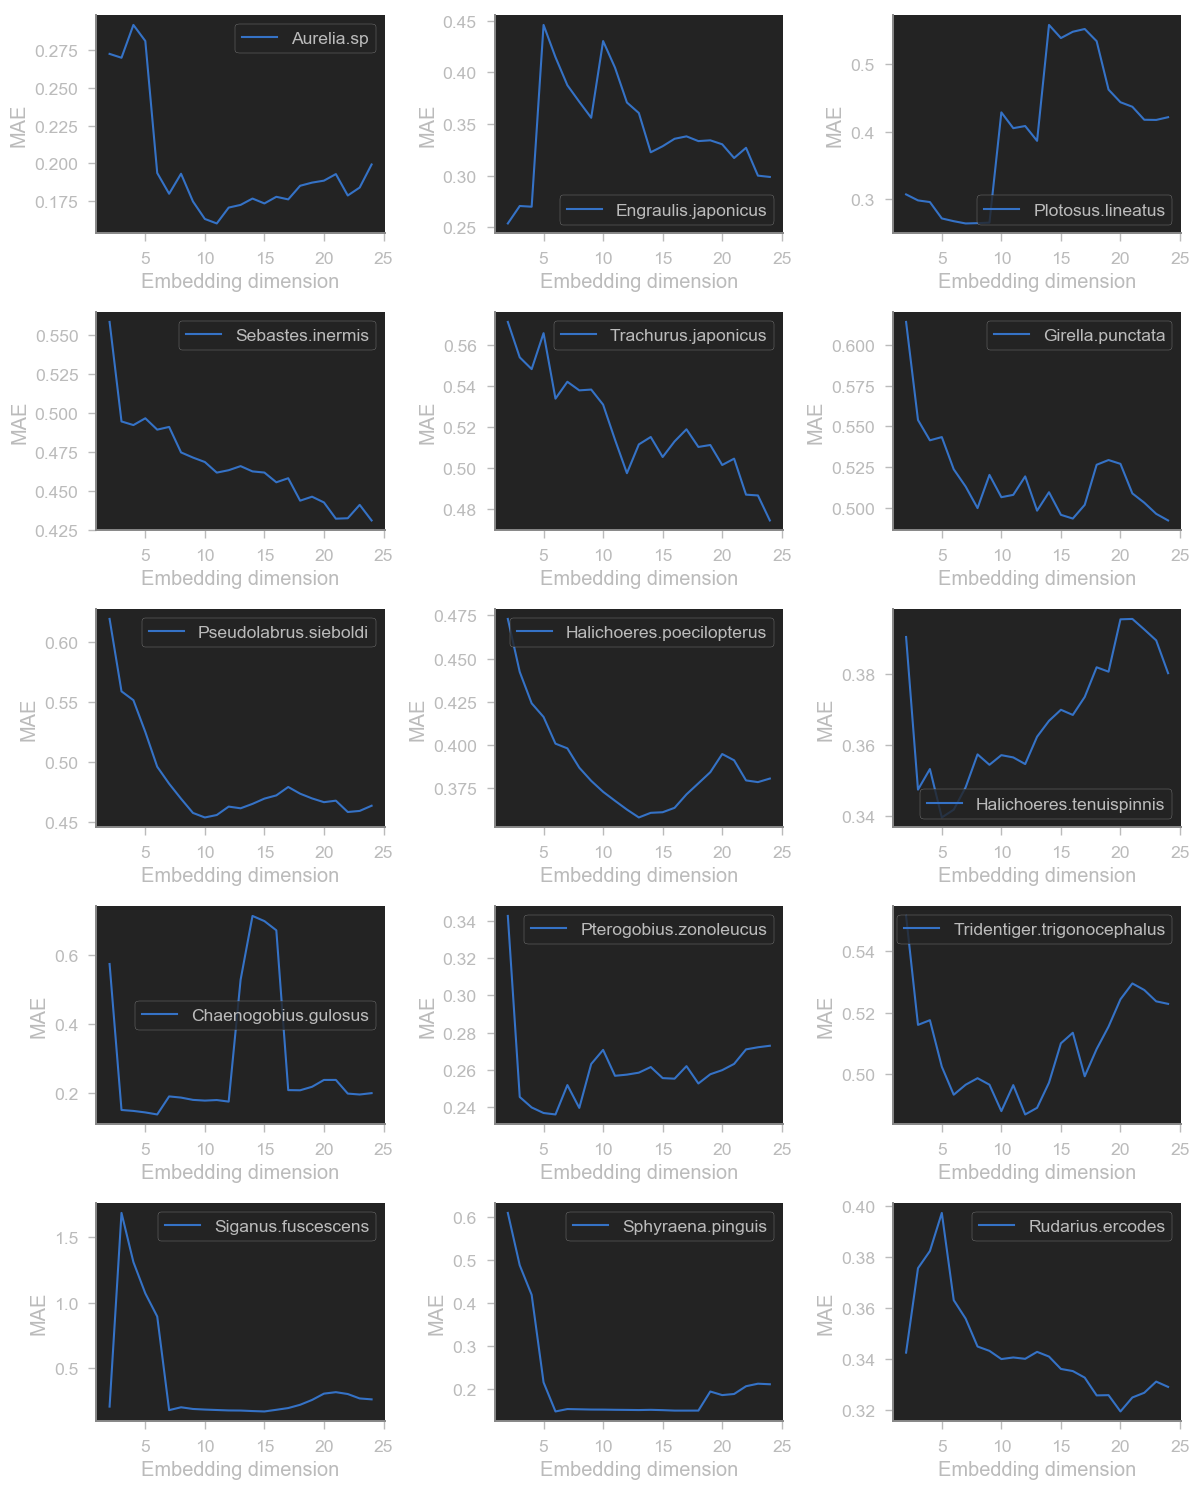

In [31]:
import numpy as np

# あとで使うので、それぞれの変数ごとにMAEが最小となるEを保存しておく。
bestEDim = pd.DataFrame(np.zeros((len(edm_data.columns[1:]), 2)), index=edm_data.columns[1:], columns=['E', 'MAE'])

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
for i, sp in enumerate(edm_data.columns[1:]):
    MAEs = np.zeros(len(range(2,25)))
    # 二次元から24次元までテスト
    for E in range(2, 25):
        library_string = "1 {}".format(len(edm_data) - E)
        # pyEDMのSimplex関数で、説明変数も予測変数も自分自身として計算
        # Tp は、何ステップ先の予測をするかのパラメータ
        preds = pyEDM.Simplex(dataFrame=edm_data, columns=sp, target=sp, \
                      E=E, Tp=1, lib=library_string, pred=library_string)
        # Mean Absolute Errorの計算
        MAEs[E-2] = np.nanmean(np.abs((preds['Predictions'] - preds['Observations']).values))

    row_ind = int(i / 3)
    col_ind = i % 3
    axes[row_ind, col_ind].plot(range(2, 25), MAEs, label=sp)
    axes[row_ind, col_ind].set_ylabel('MAE')
    axes[row_ind, col_ind].set_xlabel('Embedding dimension')
    axes[row_ind, col_ind].legend()
    
    # MAE最小のEを記録しておく
    best_E = np.argmin(MAEs) + 2
    bestEDim.loc[sp, 'E'] = best_E
    bestEDim.loc[sp, 'MAE'] = MAEs[best_E - 2]

sns.despine()
fig.tight_layout()
plt.show()

これで、以下のように埋め込み次元が決定できた。  
(一年じゃ足りないっぽいやつもいるけど)

In [32]:
bestEDim

E       MAE
Aurelia.sp                   11.0  0.160055
Engraulis.japonicus           2.0  0.253630
Plotosus.lineatus             7.0  0.264543
Sebastes.inermis             24.0  0.430862
Trachurus.japonicus          24.0  0.474158
Girella.punctata             24.0  0.492158
Pseudolabrus.sieboldi        10.0  0.453598
Halichoeres.poecilopterus    13.0  0.358027
Halichoeres.tenuispinnis      5.0  0.339525
Chaenogobius.gulosus          6.0  0.137588
Pterogobius.zonoleucus        6.0  0.235945
Tridentiger.trigonocephalus  12.0  0.486932
Siganus.fuscescens           15.0  0.169051
Sphyraena.pinguis             6.0  0.147641
Rudarius.ercodes             20.0  0.319352

# 非線形決定論的力学系か確率過程か区別する
---
EDMは、非線形決定論的過程に強く支配されるシステムを解析する手法で、（線形）確率過程で駆動されるシステムには適用できない。  
なので、なんとかして観測データのみから、そのダイナミクスが従うシステムが非線形力学系なのか確率過程なのかを区別したい。  
<br/>
ちゃんと区別できるのかテストするために、2種類のテスト時系列データを作ってみる。  
ひとつは確率過程の時系列として単純なランダムウォーク、もうひとつは以下の式に従って生成したCoupled logistic mapの（片方の）時系列データ。  
$$
X(t+1) = X(t) {(r_X - r_X X(t) - b_{yx} Y(t))}
$$
$$
Y(t+1) = Y(t) {(r_Y - r_Y Y(t) - b_{xy} X(t))}
$$

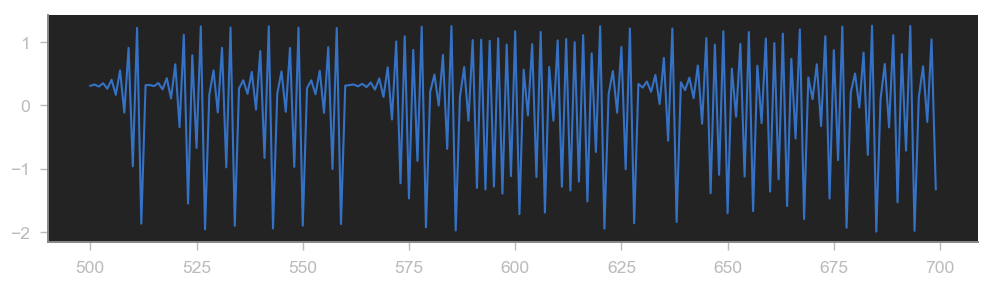

In [33]:
def coupled_logistic(rx1, rx2, b12, b21, length):
    x1 = np.zeros(length)
    x2 = np.zeros(length)
    x1[0] = 0.2
    x2[0] = 0.4
    for i in range(length-1):
        x1[i+1] = x1[i] * (rx1 - rx1 * x1[i] - b21 * x2[i])
        x2[i+1] = x2[i] * (rx2 - rx2 * x2[i] - b12 * x1[i])
    return x1,x2

x1, x2 = coupled_logistic(3.72, 3.72, 0.2, 0.01, 1000)
# 舞鶴湾データと同じように標準化
x1 = scaler.fit_transform(x1.reshape((len(x1),1))).ravel()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(range(500,700), x1[500:700], color='b')
sns.despine()
plt.show()

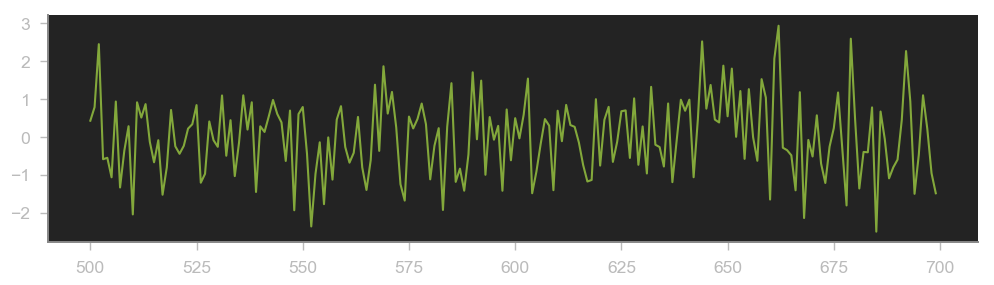

In [34]:
def brownian_motion(length):
    noise = np.random.normal(scale=1.0, size=length)
    return np.cumsum(noise)

x3 = brownian_motion(1001)
# トレンド除去のため一階差分をとる
x3 = np.array([j-i for i, j in zip(x3[:-1], x3[1:])])
x3 = scaler.fit_transform(x3.reshape((len(x3),1))).ravel()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(range(500, 700), x3[500:700], color='g')
sns.despine()
plt.show()

非線形力学系の特徴はダイナミクスの「状態依存性」にある。  
つまり非線形力学系に従うデータの場合、状態空間で近い座標にある２つのデータ点は次のステップでも互いに近い点に移るはず。  
そこで、状態空間で自分自身の未来予測をおこなうときに、どの程度「状態空間における近傍」が予測精度に寄与するかを調べれば、それが系の非線形性を反映しているはずだから、非線形システムと線形システムを区別できる。  
<br/>
このチェックは、S-map (Sequential locally weighted global linear map)と呼ばれる手法で計算できる。  
S-mapアルゴリズムの詳細は後述するが、やってることはSimplex projectionとすごく似ている。  
ただし、Simplex projectionでは近傍E+1個の点のみを使って未来予測していたのに対して、S-mapは状態空間上のすべての点を予測に使う。  
そのかわり、$\theta$ パラメータでそれぞれの点の重みを制御する。$\theta$がゼロの場合はすべての点が等しい重みで、この場合予測器はベクトル自己回帰モデル（VAR）と一致する。$\theta$が大きいと予測のときにほとんど近傍しか見ない。
なので、いろんな$\theta$でS-map未来予測をやってみて、$\theta$が大きくなるほど予測精度が大きくなれば非線形システム、そうでない場合は確率過程の影響が強いシステム、と判断できる。（実際のデータは$\theta$が大きすぎると観測ノイズの影響がでかくなって予測が外れやすくなるので$\theta$の増大に応じてどこかで頭打ちになるか下がっていくと思う。$\theta = 0$のときの予測より高い精度がどこかの$\theta$で達成されるかみればいいのかも）  
<br/>
`pyEDM`では、自分で様々な$\theta$で`SMap`関数を使うか、あるいは`PredictNonlinear`関数を使うと勝手に0.01から9.0の$\theta$でテストしてくれる。

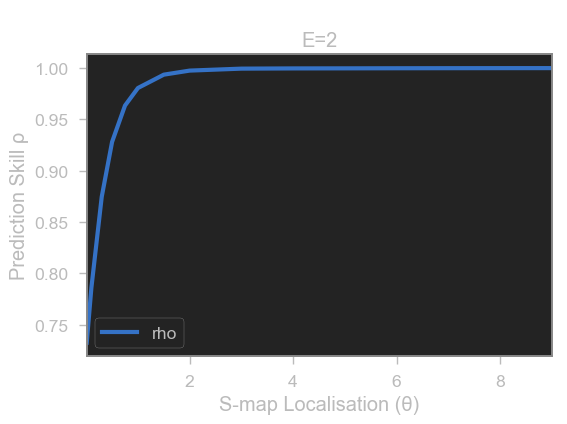

In [35]:
x1_df = pd.DataFrame(x1.reshape((len(x1), 1)), index=range(len(x1)), columns=['X1'])
x1_df.insert(loc=0, column='Time', value=range(len(x1_df)))
RHOs = pyEDM.PredictNonlinear(dataFrame=x1_df, columns='X1', target='X1', \
                                  lib = "1 200", pred = "301 500", E=2, Tp=1)

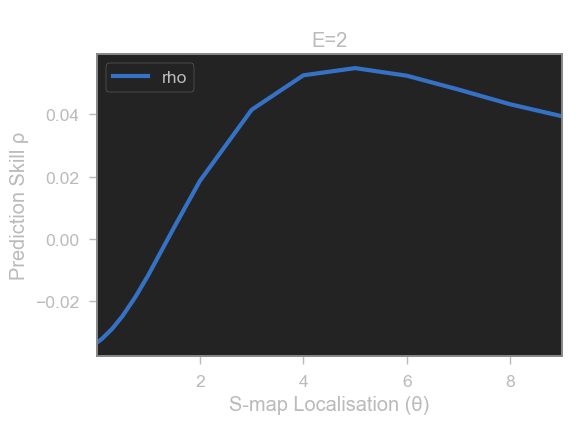

In [36]:
x3_df = pd.DataFrame(x3.reshape((len(x3), 1)), index=range(len(x3)), columns=['X3'])
x3_df.insert(loc=0, column='Time', value=range(len(x3_df)))
RHOs = pyEDM.PredictNonlinear(dataFrame=x3_df, columns='X3', target='X3', \
                                  lib = "1 200", pred = "301 500", E=2, Tp=1)

非線形力学系（coupled logistic）のデータは、予想通り$\theta$の増大に応じて予測精度が上がっていた。  
一方ランダムウォークのデータは予測精度が変な挙動をしている。なので非線形力学系じゃないっぽい（EDMの適用が適切ではない）データということがわかる。  
<br/>
それでは実際に、舞鶴湾の15種に関して計算してみる。それぞれの変数の埋め込み次元は、前項で推定した次元数で計算する。

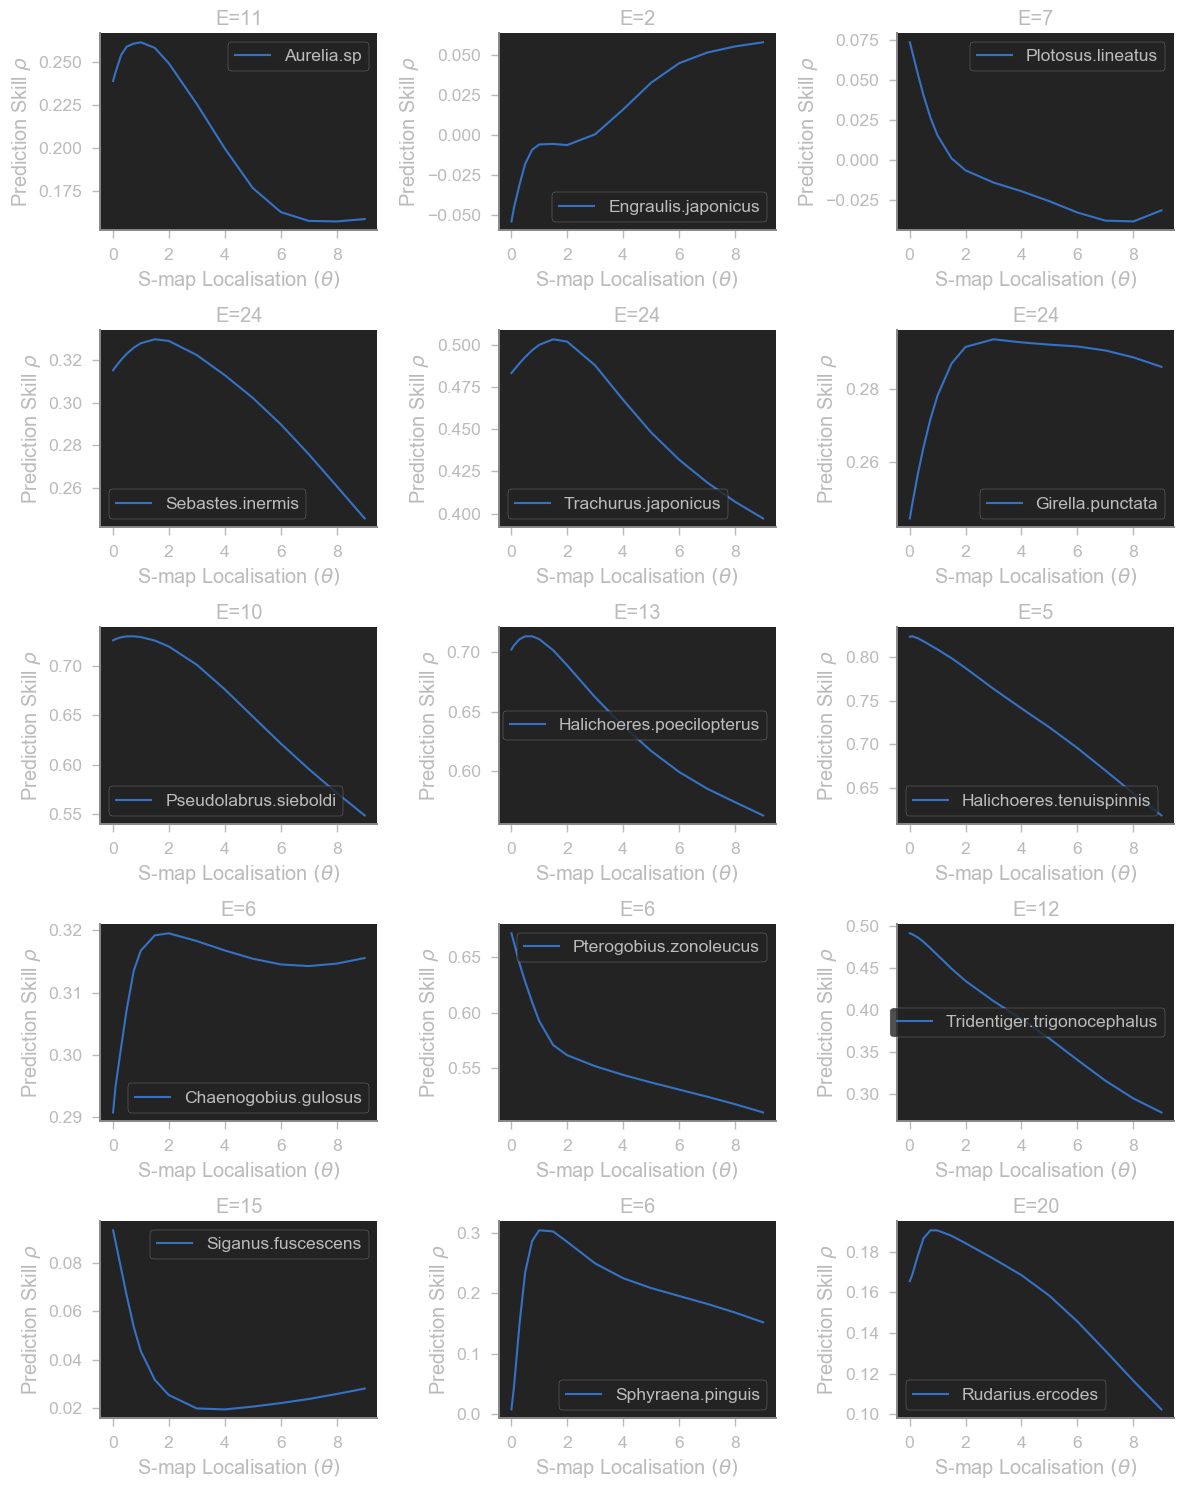

In [37]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
for i, sp in enumerate(edm_data.columns[1:]):
    temp = pyEDM.PredictNonlinear(dataFrame=edm_data, columns=sp, target=sp, \
                                  lib = "1 200", pred = "1 200", E=int(bestEDim.loc[sp, 'E']), Tp=1, showPlot=False)

    row_ind = int(i / 3)
    col_ind = i % 3
    axes[row_ind, col_ind].plot(temp['Theta'], temp['rho'], label=sp)
    axes[row_ind, col_ind].set_xlabel(r'S-map Localisation $(\theta)$')
    axes[row_ind, col_ind].set_ylabel(r'Prediction Skill $\rho$')
    axes[row_ind, col_ind].set_title('E={}'.format(int(bestEDim.loc[sp, 'E'])))
    axes[row_ind, col_ind].legend()    
sns.despine()
fig.tight_layout()
plt.show()

`PredictNonlinear`関数はやっぱり相関係数でしか予測精度を測ってくれないっぽいので、MAEとか自分で計算したい場合は適当に$\theta$のレンジを決めて`SMap`関数を使う。

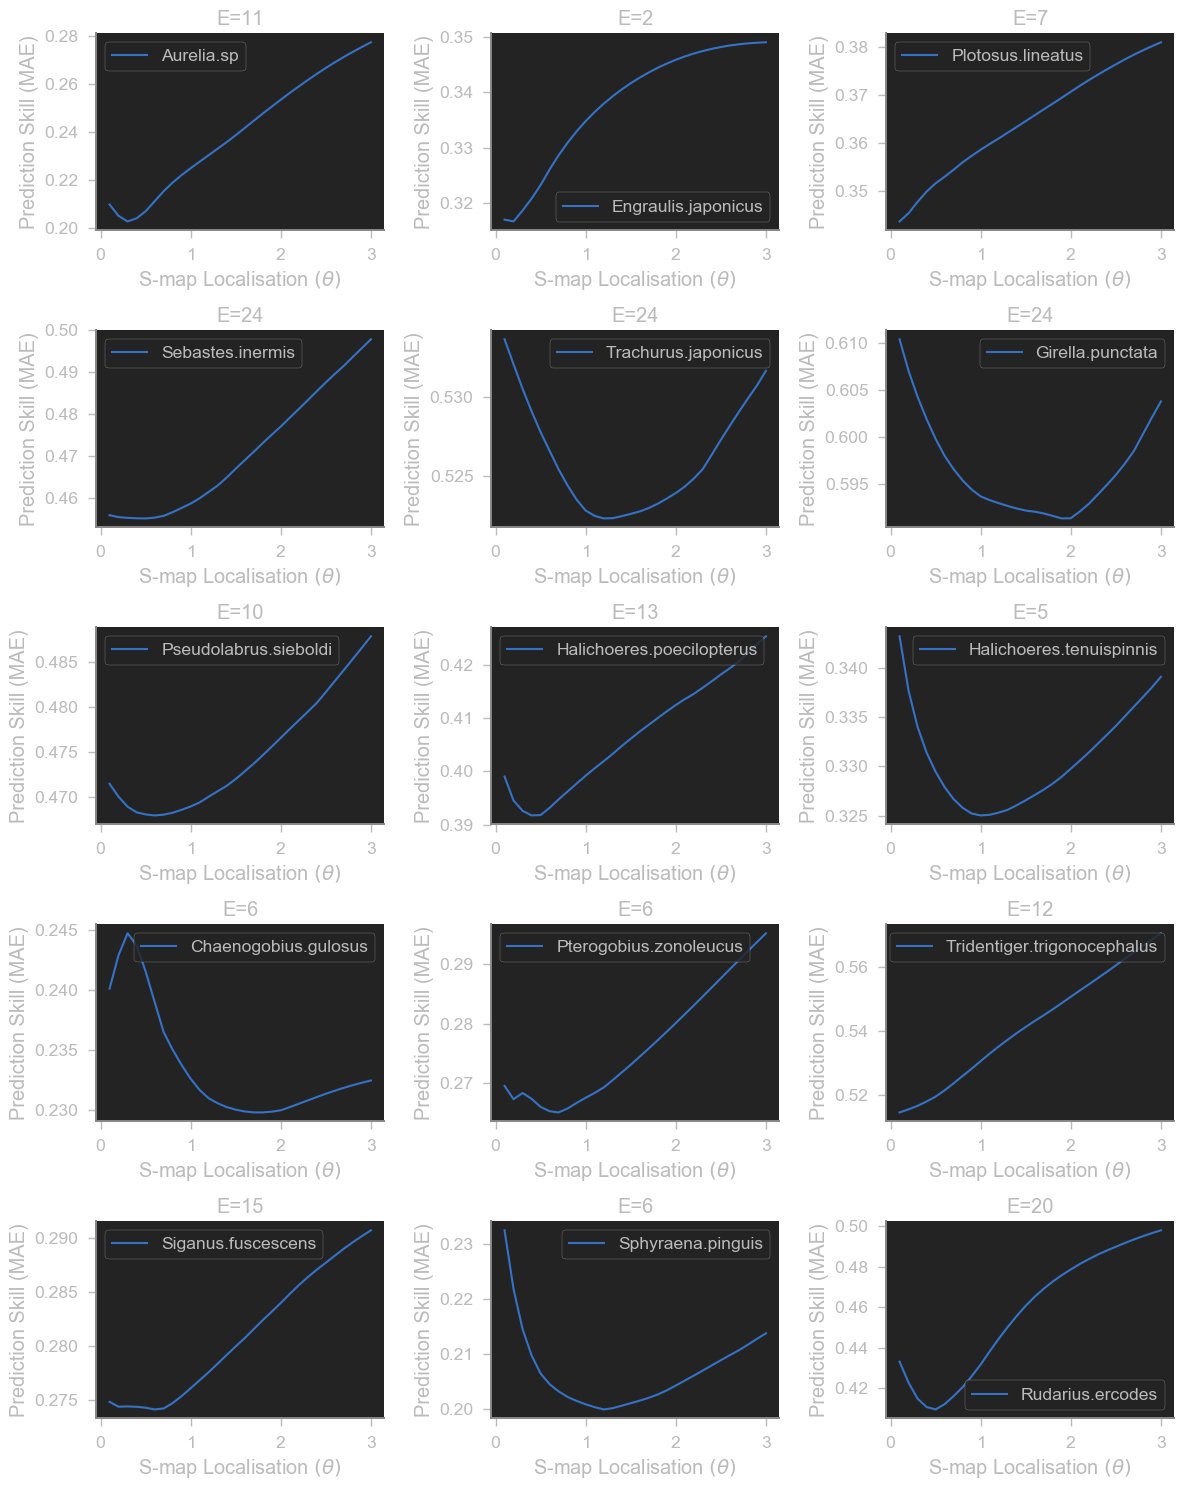

In [38]:
THETAs = np.arange(0.1, 3.1, 0.1)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
for i, sp in enumerate(edm_data.columns[1:]):
    E = int(bestEDim.loc[sp, 'E'])
    library_string =  "1 {}".format(len(edm_data) - E)
    MAEs = np.zeros(len(THETAs))
    for t, theta in enumerate(THETAs):
        temp = pyEDM.SMap(dataFrame=edm_data, columns=sp, target=sp, \
                      E=E, Tp=1, lib=library_string, pred=library_string, theta=theta)
        mae = np.abs((temp['predictions']['Predictions'] - temp['predictions']['Observations']).values[1:-1]).mean()
        MAEs[t] = mae
        
    row_ind = int(i / 3)
    col_ind = i % 3
    axes[row_ind, col_ind].plot(THETAs, MAEs, label=sp)
    axes[row_ind, col_ind].set_xlabel(r'S-map Localisation $(\theta)$')
    axes[row_ind, col_ind].set_ylabel('Prediction Skill (MAE)')
    axes[row_ind, col_ind].set_title('E={}'.format(int(bestEDim.loc[sp, 'E'])))
    axes[row_ind, col_ind].legend()    
sns.despine()
fig.tight_layout()
plt.show()

いくつか、たとえばPlotosus.lineatusとか、非線形システムとはみなせなさそうなやつ（$\theta = 0$で一番予測精度が良くて、大きくしてくと下がっていく）もいるけど、おおむね非線形性に支配されてるっぽいことがわかる。

# Convergent Cross Mappingを計算する
---
CCMについては、ウェブ上に良い資料がたくさんあるので詳細は省略する。簡単にいってしまえば、時系列データについて「相関」と「因果」をちゃんと区別する手法。  
Simplex projectionとかS-mapの考え方を複数の変数の交互の予測に拡張した手法で、相互作用のある非線形力学系ならばTakens' theoremにより、お互いの時間遅れ埋め込みの情報を使って相手の時間遅れ埋め込みを再構成できる（自分の時系列のみから相手の時系列を予測できる）という特徴を利用している。  
XとYが絡み合っている非線形力学系がアトラクタ$M_{XY}$を構成しているとき、Takens' theoremからXの時間遅れ状態ベクトル集合$M_X$は$M_{XY}$の埋め込みになる。Yの時間遅れ状態ベクトル集合$M_Y$も$M_{XY}$の埋め込みになる。従って、$M_X$は$M_Y$の埋め込みになるし、逆も成り立つ。埋め込みは滑らかに一対一対応してるわけだから、どちらか一方からもう一方を予測できる。  
一方向にしか因果関係がない場合、たとえばXの変動はYの変動に大きく影響を与えるがYの変動はXの変動にほとんど影響しないとき（X→Yの因果）、$M_Y$は$M_{XY}$の埋め込みになるが、$M_X$は$M_{XY}$の埋め込みにならない（一対一対応しない）。なので、$M_{Y}$を使って元の$M_{XY}$の予測が精度高くできる（ためXの予測もできる）一方で、$M_X$からは$M_{XY}$の予測ができない。このような予測精度の偏りをみることで、一方向の因果関係なのか双方向なのかを区別できる。  
<br/>
たとえば以下のような系を考える。さっきと同じ coupled logistic map で二変数, x1, x2が絡み合っている。  
$b_{12} = 0.2, b_{21} = 0.01$なので、x1の挙動がx2の変動に大きく影響して、x2の挙動はx1の挙動にちょっとだけ影響する。 

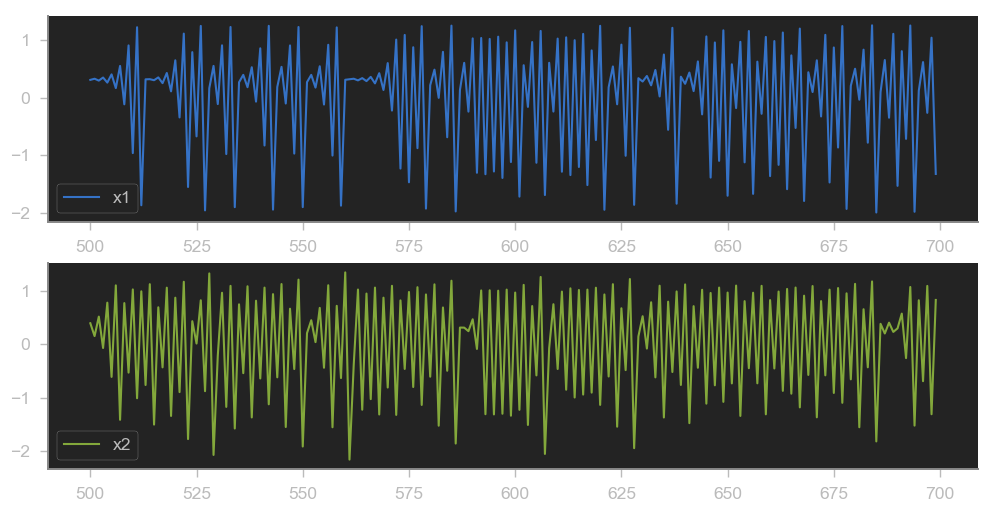

In [39]:
x1, x2 = coupled_logistic(3.72, 3.72, 0.2, 0.01, 1000)  # b(1 -> 2) = 0.2, b(2 -> 1) = 0.01

x1 = scaler.fit_transform(x1.reshape((len(x1),1)))
x2 = scaler.fit_transform(x2.reshape((len(x2),1)))
X = pd.DataFrame(np.hstack((x1, x2)), index=range(len(x1)), columns=['x1','x2'])
X.insert(loc=0, column='Time', value=range(len(X)))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
axes[0].plot(range(500,700), X['x1'].iloc[500:700], color='b', label='x1')
axes[1].plot(range(500,700), X['x2'].iloc[500:700], color='g', label='x2')
axes[0].legend(); axes[1].legend()
sns.despine()
plt.show()

この系はお互いがお互いに影響しあっていて明らかに因果関係があるのだが、通常の相関係数の計算ではほとんど検出できない。  
（状態に依存して局所的に同相同期・逆相同期・非同期いずれにもなる。全体平均すると相関係数はほぼゼロ）

In [40]:
import scipy.stats
print('Pearson: {:.2f}'.format(scipy.stats.pearsonr(X['x1'], X['x2'])[0]))
print('Spearman: {:.2f}'.format(scipy.stats.spearmanr(X['x1'], X['x2'])[0]))
print('Kendall: {:.2f}'.format(scipy.stats.kendalltau(X['x1'], X['x2'])[0]))

Pearson: 0.08
Spearman: 0.08
Kendall: 0.06


CCMを計算してみる。`CCM`関数を使うと勝手に両方向のCCMを計算してくれる。

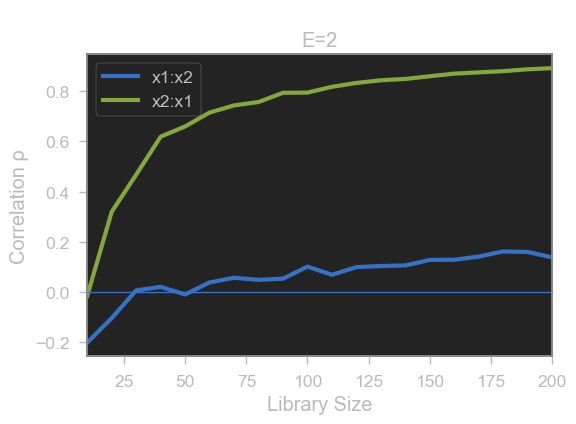

In [41]:
results = pyEDM.CCM(dataFrame = X, \
        E = 2, Tp=0, columns = 'x1', target = 'x2', \
        libSizes = "10 200 10", random=True, sample = 100, verbose = True,  showPlot = True) 

CCMは、さまざまなライブラリサイズで相手のデータを予測して、ライブラリサイズの増大に応じて convergence が観測されるかどうかで評価する。 
ここでライブラリサイズとは、時系列データからランダムサンプリングした「局所的」な時系列データのこと。ライブラリサイズが10なら、10個の連続したデータだけ使って予測する。当然短いライブラリサイズだと埋め込みがスカスカになるので、予測精度は低い。それを長くしていったときにちゃんと予測精度が上がっていっているなら、最終的な（ライブラリサイズ最大の）相関係数$\rho$の値の信頼性が高いといえる。  
上の図の場合、x1:x2が、「x1の埋め込みを使ってx2を予測したときの予測精度」、x2:x1が、「x2の埋め込みを使ってx1を予測したときの予測精度」を描いている。  
ちょっと混乱しそうになるけど、非線形力学系で因果がある場合、「結果側の変数の埋め込み」の中に原因側の変数の情報が含まれている = 結果側の変数の埋め込みを使うと原因側のデータを高精度に予測できる、ことに注意。  
この場合、x2:x1が高い値を示しているので、x2の中にx1の情報がふんだんに含まれている、つまり x1→x2の方向に強い因果がある、ということ。  
一方、x2→x1の方向の因果は弱い。なので、このデータを生成したときのパラメータの大小が（観測データのみを使った計算であるにも関わらず）ちゃんと反映されている。

In [42]:
results

LibSize     x1:x2     x2:x1
0      10.0 -0.201202 -0.015144
1      20.0 -0.103387  0.319509
2      30.0  0.006807  0.467291
3      40.0  0.020755  0.618532
4      50.0 -0.009218  0.659299
5      60.0  0.038547  0.714597
6      70.0  0.056944  0.743010
7      80.0  0.048757  0.756428
8      90.0  0.053319  0.793208
9     100.0  0.101402  0.794001
10    110.0  0.068885  0.816999
11    120.0  0.099349  0.832364
12    130.0  0.103855  0.842974
13    140.0  0.106113  0.848234
14    150.0  0.128216  0.859044
15    160.0  0.128728  0.869317
16    170.0  0.141441  0.874426
17    180.0  0.161895  0.879212
18    190.0  0.159595  0.886682
19    200.0  0.138132  0.891317

次に、完全に独立に変動している２つのランダムウォーク系列について計算してみる。

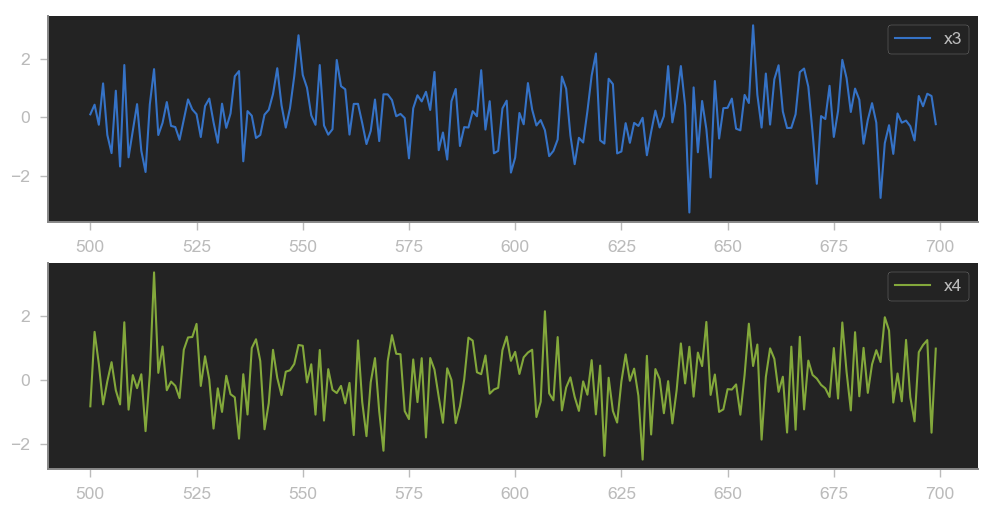

In [43]:
x3 = brownian_motion(1001)
x4 = brownian_motion(1001)

x3 = np.array([j-i for i, j in zip(x3[:-1], x3[1:])]) # 一階差分
x4 = np.array([j-i for i, j in zip(x4[:-1], x4[1:])]) 
x3 = scaler.fit_transform(x3.reshape((len(x3),1)))
x4 = scaler.fit_transform(x4.reshape((len(x4),1)))

X = pd.DataFrame(np.hstack((x3, x4)), index=range(len(x3)), columns=['x3','x4'])
X.insert(loc=0, column='Time', value=range(len(X)))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
axes[0].plot(range(500,700), X['x3'].iloc[500:700], color='b', label='x3')
axes[1].plot(range(500,700), X['x4'].iloc[500:700], color='g', label='x4')
axes[0].legend(); axes[1].legend()
sns.despine()
plt.show()

In [44]:
print('Pearson: {:.2f}'.format(scipy.stats.pearsonr(X['x3'], X['x4'])[0]))
print('Spearman: {:.2f}'.format(scipy.stats.spearmanr(X['x3'], X['x4'])[0]))
print('Kendall: {:.2f}'.format(scipy.stats.kendalltau(X['x3'], X['x4'])[0]))

Pearson: 0.06
Spearman: 0.06
Kendall: 0.04


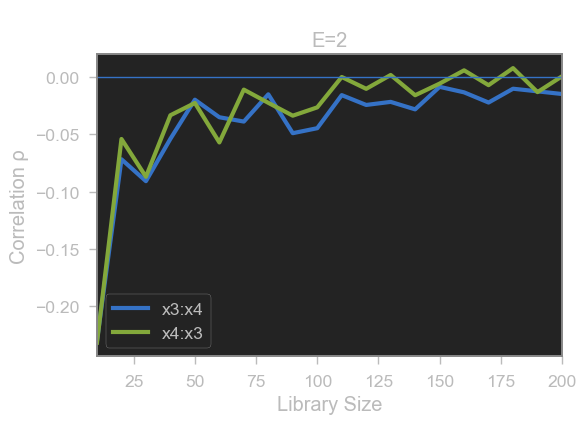

In [45]:
results = pyEDM.CCM(dataFrame = X, \
        E = 2, Tp = 0, columns = 'x3', target = 'x4', \
        libSizes = "10 200 10", sample = 100, verbose = True,  showPlot = True) 

こんな感じで、この2系列の場合は最終的な$\rho$もほぼゼロ、お互いに因果関係にないことがちゃんとCCMでも計算できた。  
<br/>
舞鶴湾のデータでも計算してみる。  
実際のデータの場合、変数によって埋め込みの次元が異なるので、同じ次元で両方向に計算するのではなく、それぞれの最適な埋め込み次元でちゃんと計算する必要がある、のだと思う。たぶん。そうするとなんで`CCM`関数は勝手に両方向で計算しちゃう設計になってるのかよくわからないが...

From: Aurelia.sp  To: Trachurus.japonicus  E = 11


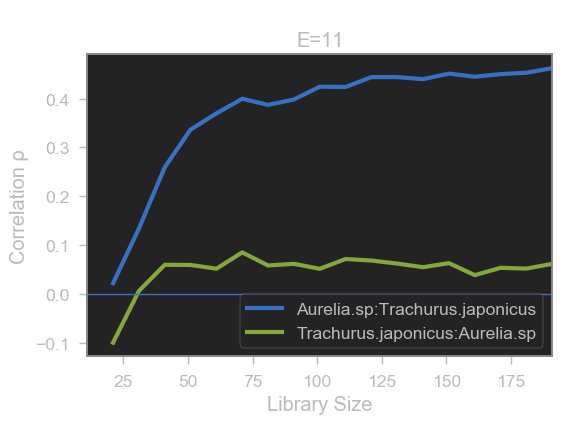

From: Trachurus.japonicus  To: Aurelia.sp  E = 24


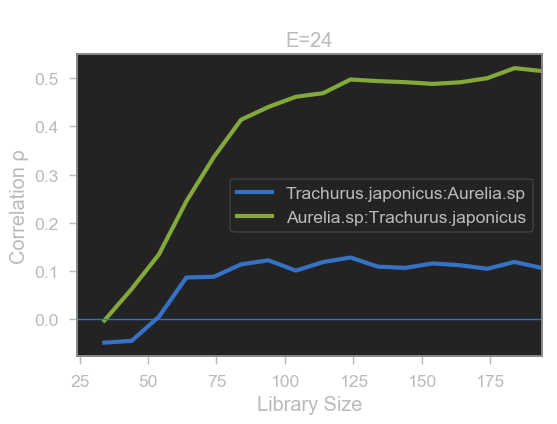

In [46]:
import itertools

sp1 = "Aurelia.sp" 
sp2 = "Trachurus.japonicus"

# 最初の方で計算した最適埋め込み次元
edim1 = int(bestEDim.loc[sp1, 'E'])
edim2 = int(bestEDim.loc[sp2, 'E'])
    
print('From:', sp1, ' To:', sp2, ' E =', edim1)
results1 = pyEDM.CCM(dataFrame = edm_data[['Time', sp1, sp2]], \
    E = edim1, Tp = 0, columns = sp1, target = sp2, \
    libSizes = f"{edim1} 200 10", sample = 100, verbose = True,  showPlot = True) 
    
print('From:', sp2, ' To:', sp1, ' E =', edim2)
results2 = pyEDM.CCM(dataFrame = edm_data[['Time', sp1, sp2]], \
    E = edim2, Tp = 0, columns = sp2, target = sp1, \
    libSizes = f"{edim2} 200 10", sample = 100, verbose = True,  showPlot = True) 

ということで、この2種の場合、Trachurus.japonicus → Aurelia.sp の因果は強い（Trachurus.japonicusの存在量の変動がAurelia.spの存在量の変動に影響を与えている）、一方、逆方向の因果は弱いことがわかった。  
この計算が、冒頭で示した図中で矢印がひかれるか否かのベースとなる情報。  
ちょっと知識なさすぎて判断できないけど、論文読むと、検出された因果関係について生態学的な考察を書いてくれている。クラゲ（Aurelia）は、マアジ（Trachurus）といっしょに飼うと長生きするらしい。

# Null modelとの比較によるCCMのsignificanceの検討

これでいいといえばいいんだけど、ちょっと注意しなきゃいけないことがあって、力学系の構造によっては、因果関係が全然ないのに高い$\rho$が検出されてしまうことがある。  
たとえば一番わかりやすいのは、因果関係にはないが共通の原因の影響を強く受けている2つの時系列データ。  
以下は前述のcoupled logistic mapで、$b_{12} = b_{21} = 0$としているので、x1とx2は独立に動く（因果関係が無い）。  
しかし共通の季節性変動の影響を強く受けている。

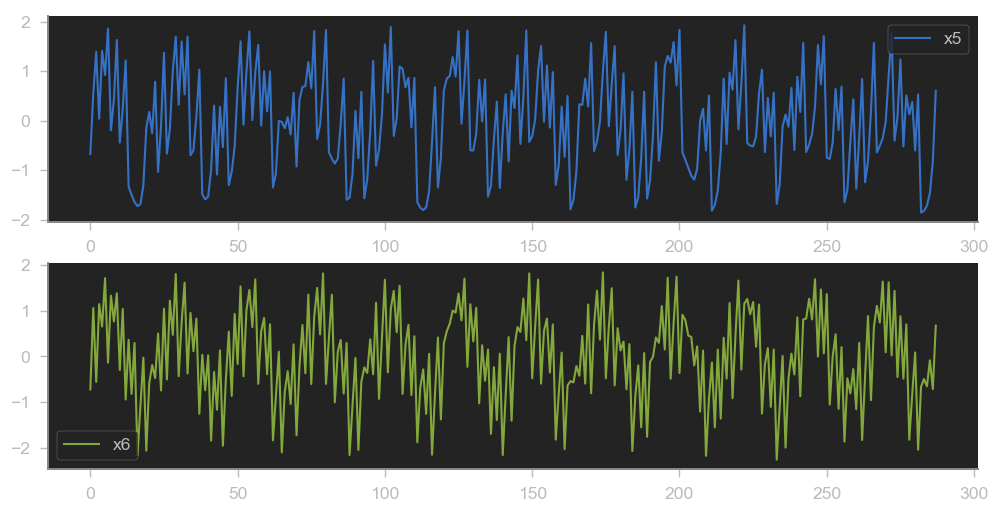

In [47]:
def seasonal_coupled_logistic(a1, a2, rx1, rx2, b12, b21, obs_per_year, n_year):
    # sin関数で一年周期の季節性変動を表現
    s = np.sin(np.linspace(0, 2*np.pi, obs_per_year+1))
    seasonality = np.tile(s[:-1], n_year)
    x1 = np.zeros(obs_per_year * n_year)
    x2 = np.zeros(obs_per_year * n_year)
    x1[0] = 0.2
    x2[0] = 0.4
    for i in range(obs_per_year * n_year -1):
        x1[i+1] = x1[i] * (rx1 - rx1 * x1[i] - b21 * x2[i])
        x2[i+1] = x2[i] * (rx2 - rx2 * x2[i] - b12 * x1[i])
    # 観測値は、それぞれの変動に季節性変動がプラスされて得られる
    return x1 + a1 * seasonality, x2 + a2 * seasonality

# お互いの相互作用（b12, b21）はゼロ
x5, x6 = seasonal_coupled_logistic(0.3, 0.3, 4, 3.8, 0.0, 0.0, 24, 12)

x5 = scaler.fit_transform(x5.reshape((len(x5),1)))
x6 = scaler.fit_transform(x6.reshape((len(x6),1)))
XS = pd.DataFrame(np.hstack((x5, x6)), index=range(len(x5)), columns=['x5', 'x6'])
XS.insert(loc=0, column='Time', value=range(len(XS)))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
axes[0].plot(range(len(XS)), XS['x5'], color='b', label='x5')
axes[1].plot(range(len(XS)), XS['x6'], color='g', label='x6')
axes[0].legend(); axes[1].legend()
sns.despine()
plt.show()

相関係数も、絡み合っているcoupled logistic mapのときより高めの値が出てしまう。

In [48]:
print('Pearson: {:.2f}'.format(scipy.stats.pearsonr(XS['x5'], XS['x6'])[0]))
print('Spearman: {:.2f}'.format(scipy.stats.spearmanr(XS['x5'], XS['x6'])[0]))
print('Kendall: {:.2f}'.format(scipy.stats.kendalltau(XS['x5'], XS['x6'])[0]))

Pearson: 0.33
Spearman: 0.32
Kendall: 0.21


In [49]:
results = pyEDM.CCM(dataFrame = XS, \
        E = 2, Tp = 0, columns = 'x5', target = 'x6',  \
        libSizes = "10 200 10", sample = 100, verbose = True,  showPlot = False) 

CCMを計算してみるときれいにconvergenceもあって、$\rho$もそれなりの値になっているので、因果関係が検出されてしまっている。

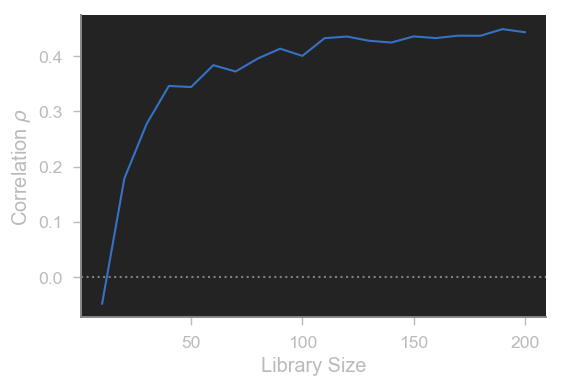

In [50]:
fig, ax = plt.subplots()
ax.plot(results['LibSize'], results['x5:x6'])
ax.axhline(y=0.0, linestyle=':', color='gray')
ax.set_xlabel('Library Size')
ax.set_ylabel('Correlation ' + r'$\rho$')
sns.despine()

したがって、本当に直接的な因果関係によって得られた高い予測精度なのかどうか判断するためには、時系列データから因果関係だけを「除去」したときにどの程度の$\rho$が得られるのか、有意性を検定しなければならない。  
しかし、適切な帰無モデルをちゃんと構成するのはけっこう大変。  
ぱっと思いつくのは、どちらか一方の時系列を完全にシャッフルしてしまってCCMを計算し、$\rho$の分布を出すことだが、これは適切では無い。シャッフルすると非線形力学系としての特徴が失われて、低い$\rho$が計算されるのは当たり前になってしまうため、「非線形力学系ではあるものの因果関係には無い」という帰無モデルとはならない。  
そこでよく使われるのが、"twin surrogate" と呼ばれる系列を構成する手法。  
twin surrogateを構成する方法については、冒頭に挙げた和文総説でわかりやすく書かれている。簡単に言うと、まず因果を断ち切りたい時系列データについて、系列中からランダムにデータ点pを選び出し、t=0の点とする。次にt=1の点として、実際の時系列におけるpの次ステップの点か、あるいは状態空間上でpと近い距離にあるデータ点かをランダムに選ぶ。つまり実際の時間通りに進む場合もあれば、時間がジャンプすることもある。これを、元の時系列の長さになるまで続ける。  
このようにサロゲートデータを構成すると、「2つの時系列の非線形力学系の性質を保ちつつ、それらの間の因果性を断ち切ったサロゲートデータ」が構成できる（らしい）。  
サロゲートデータ（帰無モデル）さえ構成できれば、「時系列A:時系列B」で計算した$\rho$と、「時系列Aのサロゲート:時系列B」で計算した$\rho$を比較することで、B→Aへの因果が有意に高いと言えるのかどうかを判断できる。  
<br/>
pyEDMにはtwin surrogateを構成するための実装が見当たらないため、論文の記述に従ってPythonで実装した。  
シンプルすぎる気もして若干不安だけど、たぶん、こういうことをやっているんだと思う。

In [51]:
from scipy.spatial.distance import pdist, squareform

def twin_surrogate(df, target='x5', e_dim=2, max_iter=100, \
                   method='original', obs_per_year=None):
    # 時間遅れ埋め込みの状態空間を作る。
    x_e = pyEDM.Embed(dataFrame=df, E=e_dim, columns=target)
    # all vs. allの距離行列を計算する。max norm.
    dist_mtx = squareform(pdist(x_e.values, metric='chebyshev'))
    # 距離行列を、距離が近い・遠いでゼロイチのマトリックスにしてしまう。どのあたりで切るかは適当...
    binary_dist_mtx = (dist_mtx > np.percentile(dist_mtx, 75.0)).astype(int)
    
    # all vs. allのペアが "twin" であるかどうかのマトリックス
    # ほかの全部との距離パターンが似ている2点は twin.
    twins_table = np.eye(len(x_e), len(x_e))
    for i, j in itertools.combinations(range(len(x_e)), 2):
        # ゼロイチパターンがすべて一致
        if np.all(binary_dist_mtx[:, i] == binary_dist_mtx[:, j]):
            if method == 'phase_lock':
                if (j-i) % obs_per_year == 0:
                    twins_table[i, j] = 1
                    twins_table[j, i] = 1
            else:
                twins_table[i, j] = 1
                twins_table[j, i] = 1

    n_iter = 0
    while True:
        failed_surrogate_generation = False
        surrogate = np.zeros((x_e.values.shape[0] + (e_dim - 1), x_e.values.shape[1]))
        # 適当な点からはじめる
        if method == 'phase_lock':
            ind = np.random.choice(np.arange(0, len(x_e), obs_per_year), 1)[0] # random sampling from same season samples
        else:
            ind = np.random.choice(len(x_e), 1)[0]
        surrogate[0, :] = x_e.values[ind, :]
        for t in np.arange(surrogate.shape[0])[1:]:
            # 次の点はオリジナル系列の t+1 か、あるいは、twin の中からランダムに選択された点
            nex = np.random.choice(np.argwhere(twins_table[ind, :]).ravel(), 1)[0] + 1
            # もし途中で系列の終端に達してしまったら全体をはじめからやり直す
            if nex >= len(x_e):
                failed_surrogate_generation = True
                break
            surrogate[t, :] = x_e.values[nex, :]
            ind = nex
        if not failed_surrogate_generation:
            break
        else:
            n_iter += 1
            if n_iter > max_iter:
                # max_iter回繰り返して全部失敗したらあきらめる
                raise Exception(f'Failed to generate surrogate in {max_iter} iterations.')

    return surrogate[:, -1]

上のtwin surrogateの実装で、`method=phase_lock`っていうのを用意している。  
実は舞鶴湾論文においては、twin surrogateでもまだ不服で、もっと保守的というか、厳しい制約を課している。  
twin surrogateの問題は、状態空間の近い点にジャンプするとき、季節的に全然連続してない点にジャンプしちゃうことがあること。そうするとサロゲートデータは途中で季節ががらっと変わっちゃうため、季節性変動は残しつつ因果関係だけ断ち切る、みたいな構成ができない。  
そこで舞鶴湾論文では`phase-lock twin surrogate`というサロゲート構成手法を提案していて、ジャンプするときに全部のtwinからランダムに選ぶのではなく、「一年の中で同じ季節に該当するtwin」のみからランダム選択するようにしている。  
<br/>
というわけで、上で作ったシミュレーションデータに関して、通常のtwin surrogateと、phase-lock twin surrogateを計算してみる。

In [52]:
x5_surrogate = twin_surrogate(XS, target='x5', e_dim=2, method='original')
x5_surrogate_phase_lock = twin_surrogate(XS, target='x5', e_dim=2, method='phase_lock', obs_per_year=24)

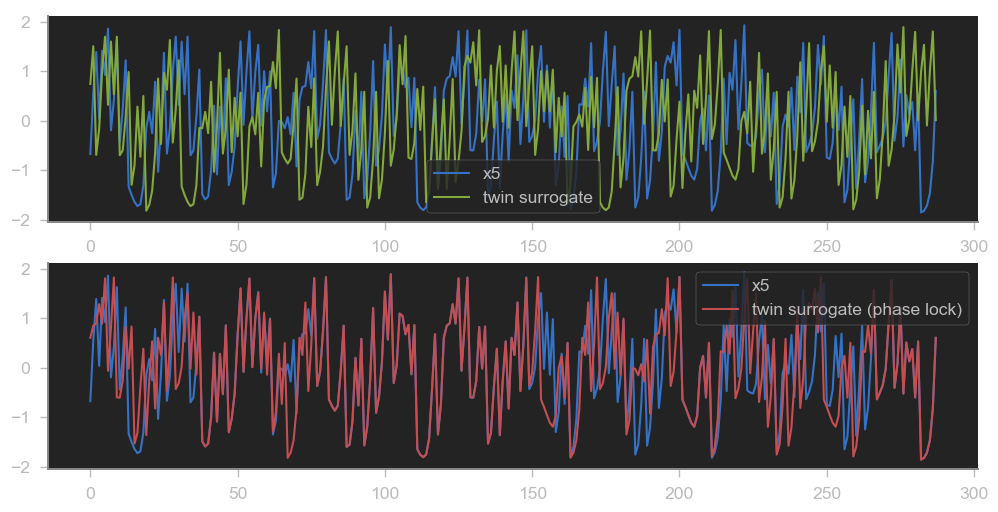

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
axes[0].plot(range(len(XS)), XS['x5'], color='b', label='x5')
axes[0].plot(range(len(XS)), x5_surrogate, color='g', label='twin surrogate')
axes[1].plot(range(len(XS)), XS['x5'], color='b', label='x5')
axes[1].plot(range(len(XS)), x5_surrogate_phase_lock, color='r', label='twin surrogate (phase lock)')
axes[0].legend(); axes[1].legend()
sns.despine()
plt.show()

通常の twin surrogate は同じ季節で真逆の変動を示してしまったりしているが、phase-lock twin surrogateはちゃんと季節性変動を反映しつつ微妙に異なる変動を示すデータとして構成できている。  
まず、通常のtwin surrogateでCCM計算してみる。

In [54]:
XS['x5_surrogate'] = x5_surrogate

x5original_x6 = pyEDM.CCM(dataFrame = XS, \
        E = 2, Tp = 0, columns = 'x5', target = 'x6',  \
        libSizes = "10 200 10", sample = 100, verbose = True,  showPlot = False) ['x5:x6']

x5surrogate_x6 = pyEDM.CCM(dataFrame = XS, \
        E = 2,  Tp = 0, columns = 'x5_surrogate', target = 'x6', \
        libSizes = "10 200 10", sample = 100, verbose = True,  showPlot = False) ['x5_surrogate:x6']

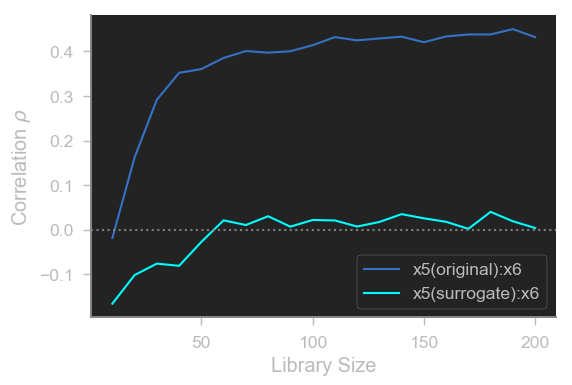

In [55]:
fig, ax = plt.subplots()
ax.plot(range(10, 210, 10), x5original_x6, color='b', label='x5(original):x6')
ax.plot(range(10, 210, 10), x5surrogate_x6, color='cyan', label='x5(surrogate):x6')
ax.axhline(y=0.0, linestyle=':', color='gray')
ax.set_xlabel('Library Size')
ax.set_ylabel('Correlation ' + r'$\rho$')
ax.legend()
sns.despine()

やはりtwin surrogateで計算すると因果性がほとんど失われる。  
次にphase-lock twin surrogateで計算してみる。

In [56]:
XS['x5_surrogate'] = x5_surrogate_phase_lock
x5surrogate_x6 = pyEDM.CCM(dataFrame = XS, \
        E = 2, columns = 'x5_surrogate', target = 'x6', Tp=0, \
        libSizes = "10 200 10", sample = 100, verbose = True,  showPlot = False) ['x5_surrogate:x6']

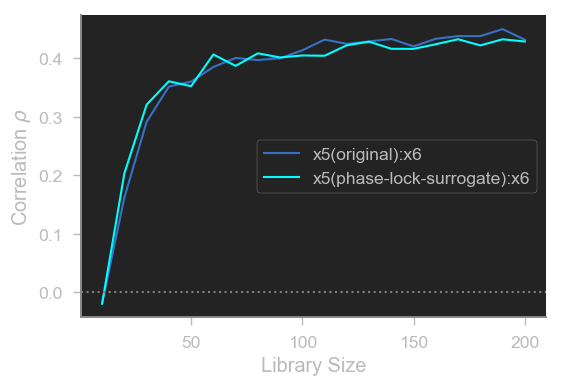

In [57]:
fig, ax = plt.subplots()
ax.plot(range(10, 210, 10), x5original_x6, color='b', label='x5(original):x6')
ax.plot(range(10, 210, 10), x5surrogate_x6, color='cyan', label='x5(phase-lock-surrogate):x6')
ax.axhline(y=0.0, linestyle=':', color='gray')
ax.set_xlabel('Library Size')
ax.set_ylabel('Correlation ' + r'$\rho$')
ax.legend()
sns.despine()

通常の二系列とサロゲートデータを比較してみると、CCMの結果にほとんど差はない。  
x5, x6の二系列はそもそも、共通の季節性変動を示すがお互いの因果関係はないもの、というシミュレーションだった。なので、実際の$\rho$がサロゲートデータ（帰無仮説）の$\rho$と比べて高いとは言えない、という結果は納得。  
<br/>
このtwin surrogate関数使って、有意性を検定してみる。とりあえず100本のサロゲートデータを作って、実際のCCMがその分布の95% confidence intervalより上にくるのか調べてみる。

In [58]:
from tqdm.notebook import tqdm

def ccm_surrogate_ConfidenceInterval(dataframe, E=2, \
        column='column', target='target', libSizes="10 200 10", \
        method='phase_lock', obs_per_year=24, n_surrogate=100, CI=95.0):
    # 普通のCCM計算
    original_rho = pyEDM.CCM(dataFrame = dataframe, \
        E = E, columns = column, target = target, Tp=0, \
        libSizes = libSizes, sample = 100, \
        verbose = True,  showPlot = False) [f'{column}:{target}']
    libSize_indices = original_rho.index
    original_rho = original_rho.values

    # 百本のサロゲート作ってそれぞれでCCM計算
    surrogate_rhos = np.zeros((len(original_rho), n_surrogate))
    for i in tqdm(range(n_surrogate)):
        surrogate = twin_surrogate(dataframe, target=column, \
                                   e_dim=E, method=method, obs_per_year=obs_per_year)
        dataframe['surrogate'] = surrogate
        surrogate_rho = pyEDM.CCM(dataFrame = dataframe, \
            E = E, columns = 'surrogate', target = target, Tp=0, \
            libSizes = libSizes, sample = 100, verbose = True,  showPlot = False) [f'surrogate:{target}'].values
        surrogate_rhos[:, i] = surrogate_rho

    result_df = pd.DataFrame(np.zeros((len(original_rho), 3)), \
                             columns=['rho', f'upper{int(CI):d}', f'lower{int(CI):d}'], index=libSize_indices)
    result_df['rho'] = original_rho
    result_df[f'upper{int(CI):d}'] = np.nanpercentile(surrogate_rhos, 100.0 - (100.0 - CI) / 2.0, axis=1)[:, np.newaxis]
    result_df[f'lower{int(CI):d}'] = np.nanpercentile(surrogate_rhos, (100.0 - CI) / 2.0, axis=1)[:, np.newaxis]
    return result_df

In [59]:
results = ccm_surrogate_ConfidenceInterval(XS, E = 2, column='x5', target='x6', libSizes="10 200 10", 
                             method='phase_lock', obs_per_year=24, n_surrogate=100, CI=95.0)

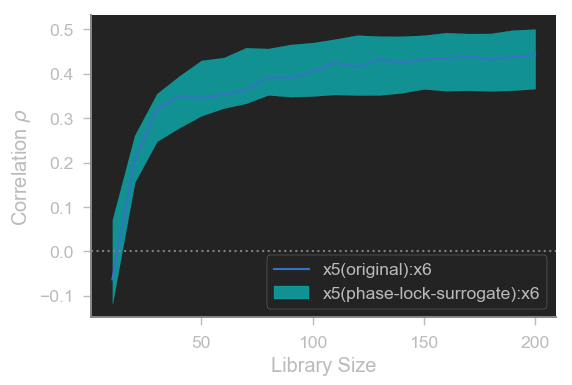

In [60]:
fig, ax = plt.subplots()
ax.plot(range(10, 210, 10), results['rho'], color='b', label='x5(original):x6')
ax.fill_between(range(10, 210, 10), results['lower95'], results['upper95'], \
                facecolor='cyan', edgecolor='cyan', alpha=0.5, label='x5(phase-lock-surrogate):x6')
ax.axhline(y=0.0, linestyle=':', color='gray')
ax.set_xlabel('Library Size')
ax.set_ylabel('Correlation ' + r'$\rho$')
ax.legend()
sns.despine()

さっきと同じ結果だけど、ちゃんとオリジナルのCCMがサロゲートの95%CIの中に入っている = x6→x5の因果は有意とは言えない。  
<br/>
次に、ちゃんと絡み合っている（お互いに因果関係がある）２つの時系列で、かつ季節性変動の影響を受けてしまっているときのCCM、サロゲートCCMを計算してみる。

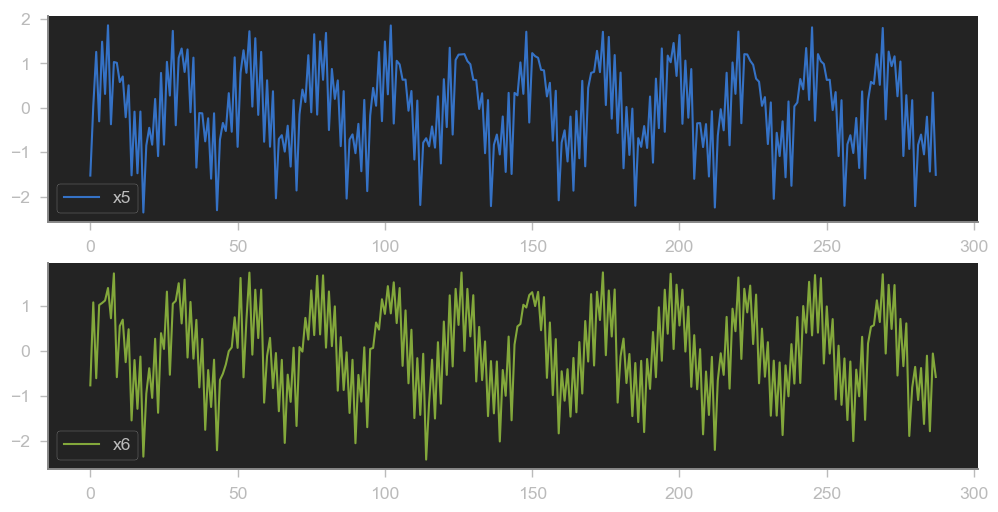

In [61]:
x5, x6 = seasonal_coupled_logistic(0.3, 0.3, 3.72, 3.72, 0.2, 0.01, 24, 12) # b(1 -> 2) = 0.2, b(2 -> 1) = 0.01

x5 = scaler.fit_transform(x5.reshape((len(x5),1)))
x6 = scaler.fit_transform(x6.reshape((len(x6),1)))
XS = pd.DataFrame(np.hstack((x5, x6)), index=range(len(x5)), columns=['x5', 'x6'])
XS.insert(loc=0, column='Time', value=range(len(XS)))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
axes[0].plot(range(len(XS)), XS['x5'], color='b', label='x5')
axes[1].plot(range(len(XS)), XS['x6'], color='g', label='x6')
axes[0].legend(); axes[1].legend()
sns.despine()
plt.show()

In [62]:
results = ccm_surrogate_ConfidenceInterval(XS, E = 2, column='x6', target='x5', libSizes="10 200 10", 
                             method='phase_lock', obs_per_year=24, n_surrogate=100, CI=95.0)

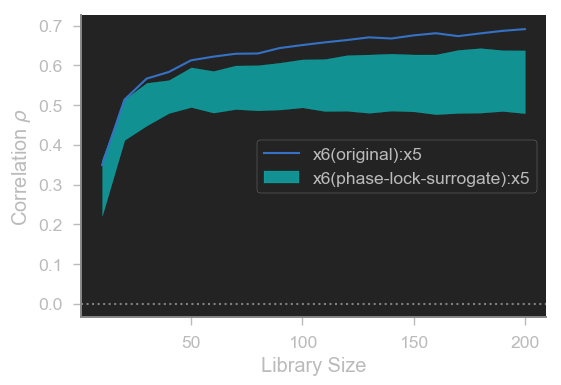

In [63]:
fig, ax = plt.subplots()
ax.plot(range(10, 210, 10), results['rho'], color='b', label='x6(original):x5')
ax.fill_between(range(10, 210, 10), results['lower95'], results['upper95'], \
                facecolor='cyan', edgecolor='cyan', alpha=0.5, label='x6(phase-lock-surrogate):x5')
ax.axhline(y=0.0, linestyle=':', color='gray')
ax.set_xlabel('Library Size')
ax.set_ylabel('Correlation ' + r'$\rho$')
ax.legend()
sns.despine()

この系の場合は、実際のCCMがちゃんとサロゲートの95%CIの上をいってくれた。なので、帰無モデルと比較して有意に$\rho$が高い、と言える。  
一方、逆方向の因果の場合、

In [64]:
results = ccm_surrogate_ConfidenceInterval(XS, E = 2, column='x5', target='x6', libSizes="10 200 10", 
                             method='phase_lock', obs_per_year=24, n_surrogate=100, CI=95.0)

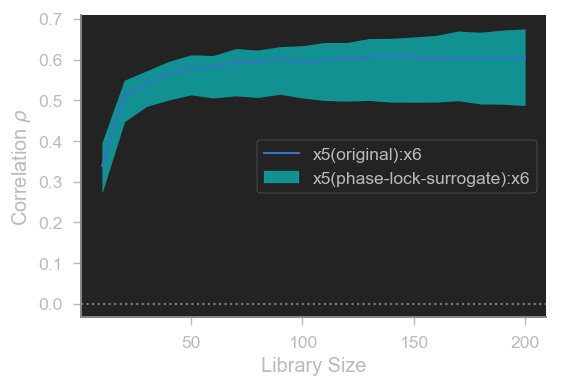

In [65]:
fig, ax = plt.subplots()
ax.plot(range(10, 210, 10), results['rho'], color='b', label='x5(original):x6')
ax.fill_between(range(10, 210, 10), results['lower95'], results['upper95'], \
                facecolor='cyan', edgecolor='cyan', alpha=0.5, label='x5(phase-lock-surrogate):x6')
ax.axhline(y=0.0, linestyle=':', color='gray')
ax.set_xlabel('Library Size')
ax.set_ylabel('Correlation ' + r'$\rho$')
ax.legend()
sns.despine()

サロゲートの中に埋もれてしまった。なので、因果があったとしてもかなり弱い場合（この系では$b_{12}=0.2$にたいして$b_{21}=0.01$）、有意性はちゃんと評価しにくいかも。phase-lock twin surrogateが保守的すぎる、自分に厳しすぎるのかもしれない（あるいは単にここで実装してるtwin surrogateのアルゴリズムが間違っているか）  
<br/>
舞鶴湾のデータでもいくつか調べてみる。

In [66]:
edm_data.columns

Index(['Time', 'Aurelia.sp', 'Engraulis.japonicus', 'Plotosus.lineatus',
       'Sebastes.inermis', 'Trachurus.japonicus', 'Girella.punctata',
       'Pseudolabrus.sieboldi', 'Halichoeres.poecilopterus',
       'Halichoeres.tenuispinnis', 'Chaenogobius.gulosus',
       'Pterogobius.zonoleucus', 'Tridentiger.trigonocephalus',
       'Siganus.fuscescens', 'Sphyraena.pinguis', 'Rudarius.ercodes'],
      dtype='object')

From: Aurelia.sp  To: Trachurus.japonicus  E = 11


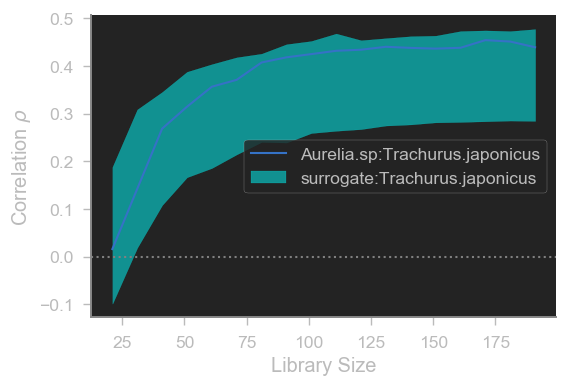

In [67]:
import warnings
warnings.simplefilter('ignore')

def ccm_two_species(sp1, sp2):
    edim1 = int(bestEDim.loc[sp1, 'E'])
    print('From:', sp1, ' To:', sp2, ' E =', edim1)        
    results = ccm_surrogate_ConfidenceInterval(edm_data[['Time', sp1, sp2]], \
        E = edim1, column=sp1, target=sp2, libSizes=f"{edim1} 200 10", \
        method='phase_lock', obs_per_year=24, n_surrogate=100, CI=95.0)

    fig, ax = plt.subplots()
    ax.plot(range(edim1, 200, 10), results['rho'], color='b', label=f'{sp1}:{sp2}')
    ax.fill_between(range(edim1, 200, 10), results['lower95'], results['upper95'], \
        facecolor='cyan', edgecolor='cyan', alpha=0.5, label=f'surrogate:{sp2}')
    ax.axhline(y=0.0, linestyle=':', color='gray')
    ax.set_xlabel('Library Size')
    ax.set_ylabel('Correlation ' + r'$\rho$')
    ax.legend()
    sns.despine()
    plt.show()

ccm_two_species('Aurelia.sp', 'Trachurus.japonicus')

論文では有意になっているはずの関係がサロゲートの分布に埋もれてしまった...  
というか、95%CIにするとほぼすべての因果関係がリジェクトされる。惜しいところまではきているんだけど...やっぱりphase-lockが厳しすぎるか、95%CIが厳しすぎるか、あるいはサロゲートの構成アルゴリズムの実装をミスってる気がする。  
80%CIくらいまで緩めると論文の結果と同じパターンが出てきたりするので、一応できたことにする。

# S-Mapによる相互作用強度の時間変動の検出
---
前項までで、因果関係のあるペア、その因果の方向が検出できた（ことにした）。  
冒頭の図の、矢印の向きがわかったことになる。最後は、この矢印の色が青なのか赤なのか、つまり因果がpositiveなのか（相手の変動にプラスに効いている＝増やす方向に働いているのか）、negativeなのかを区別したい。  
これは、最初の方で紹介したS-Mapで計算できる。S-Mapが何を計算しているのか、すこし詳細に見てみる。  
<br/>
そのためのテストデータとして、以下のシンプルな生態系モデルを考える。3種、3階層の食物連鎖のモデルで、PはCを食って、CはRを食って、Rは勝手に増える。  
<br/>
$$
\frac{dP}{dt} = \nu \lambda \frac{PC}{C + 0.5} - \nu P \\
\frac{dC}{dt} = \mu \kappa \frac{CR}{R + 0.3} - \nu \lambda \frac{PC}{C + 0.5} - \mu C \\
\frac{dR}{dt} = R \left( 1 - \frac{R}{k} \right) - \mu \kappa \frac{CR}{R + 0.3}
$$

In [68]:
def dPdt(P, nu, lam, C):
    return nu * lam * P * C / (C + 0.5) - nu * P

def dCdt(C, mu, kappa, nu, lam, P, R):
    return mu * kappa * C * R / (R + 0.3) - nu * lam * P * C / (C + 0.5) - mu * C

def dRdt(R, k, mu, kappa, C):
    return R * (1. - R / k) - mu * kappa * C * R / (R + 0.3)

def three_species_food_chain(nu, lam, mu, kappa, k, length=10000):
    delta_t = 0.01
    decimate_step = 50
    P = np.zeros(decimate_step*length); P[0] = .5
    C = np.zeros(decimate_step*length); C[0] = .5
    R = np.zeros(decimate_step*length); R[0] = .5
    for t in range(1, decimate_step*length): # オイラー法で数値計算
        P[t] = P[t-1] + delta_t * dPdt(P[t-1], nu, lam, C[t-1])
        C[t] = C[t-1] + delta_t * dCdt(C[t-1], mu, kappa, nu, lam, P[t-1], R[t-1])
        R[t] = R[t-1] + delta_t * dRdt(R[t-1], k, mu, kappa, C[t-1])
    decimate = np.arange(0, decimate_step*length, decimate_step) # decimate_step ごとに間引く
    return P[decimate], C[decimate], R[decimate]

nu = 0.1
lam = 3.2
mu = 0.15
kappa = 2.5
k = 1.2
length = 4000
P, C, R = three_species_food_chain(nu, lam, mu, kappa, k, length=length)

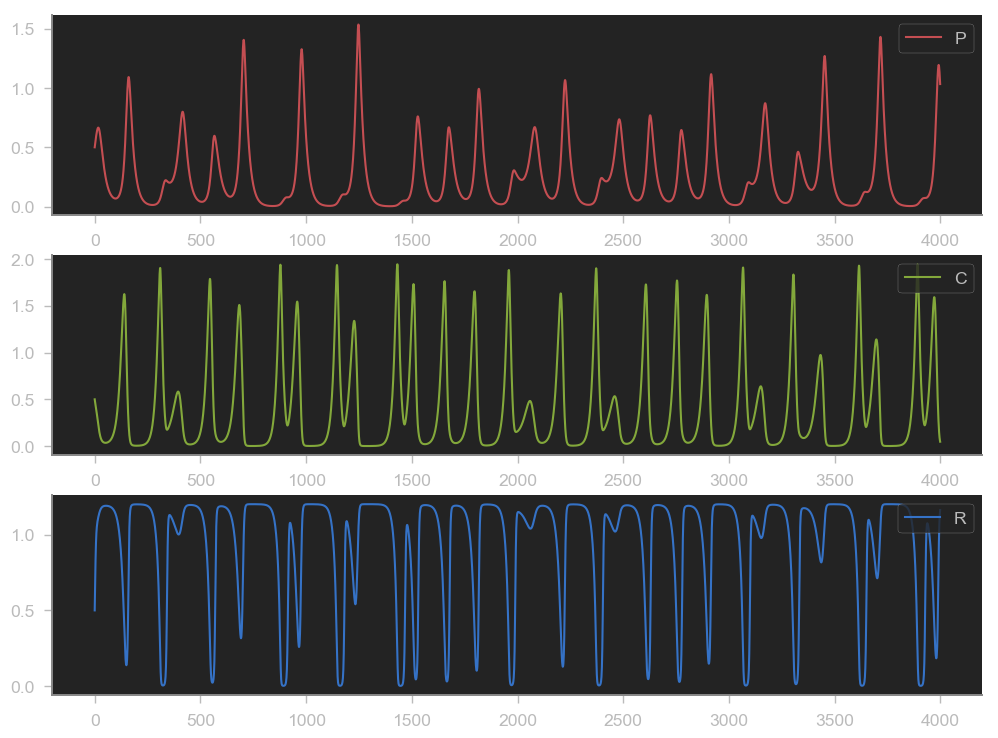

In [69]:
start = 0
end = 4000
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,9))
axes[0].plot(range(length)[start:end], P[start:end], color='r', label='P')
axes[1].plot(range(length)[start:end], C[start:end], color='g', label='C')
axes[2].plot(range(length)[start:end], R[start:end], color='b', label='R')
axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); axes[2].legend(loc='upper right')
sns.despine()
plt.show()

P, C, Rそれぞれこんな感じの動態になる。わりと予測しやすそうな動きをしているけど、完全に周期的ってわけでもなく不規則に変動している。  
「相互作用の時間変動」といったときにいろんな考え方があると思うけど、ここではタイムポイントごとの力学系の偏微分を考える。  
モデルの数式がわかってる場合は解析的?に計算ができて、下のようになる。（たぶん）

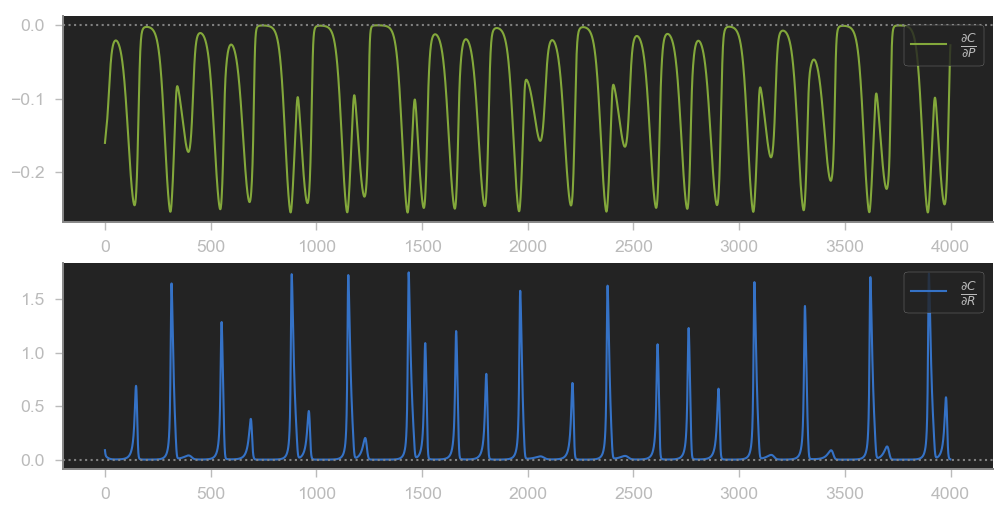

In [70]:
delC_delP = -1.0 * nu * lam * C / (C + 0.5)
delC_delR = 0.3 * mu * kappa * C / (R + 0.3) ** 2

start = 0
end = 4000
fig, axes = plt.subplots(nrows=2, figsize=(12,6))
axes[0].plot(range(length)[start:end], delC_delP[start:end], color='g', \
             label=r'$\frac{\partial C}{\partial P}$')
axes[1].plot(range(length)[start:end], delC_delR[start:end], color='b', \
             label=r'$\frac{\partial C}{\partial R}$')
axes[0].axhline(y = 0.0, color='gray', linestyle=':')
axes[1].axhline(y = 0.0, color='gray', linestyle=':')
axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right')
sns.despine()
plt.show()

各タイムポイントにおけるそれぞれの存在量に応じてCに与える影響の強さには変動がある。しかし少なくとも時系列全体を通して、PはCに対して負の影響を与え、RはCに対して正の影響を与えていることはわかる。この偏微分の符号を、相互作用の正負と考えることにする。  
この場合は力学系の数式がわかっていた、つまり$\nu$や$\mu$などのパラメータの値がわかっていたためこういった計算ができるが、現実には観測データしか手元にない。そこで、観測データのみからこのような偏微分を（力学系モデルの仮定なしで）推定する手法がS-Mapである。　　
<br/>   
やっていることは、多変量の時系列観測値のデータを説明変数として、ある変数についてTpステップ先の値を予測変数とし、線形回帰のモデルを作る。これだけ。  
つまりTpステップぶんで局所的に線形性を仮定している。こうやって推定された各変数の回帰係数を、そのタイムポイントにおける偏微分値とする。  
<br/>
タイムポイントひとつひとつでそれぞれ線形回帰モデルを作って回帰係数を計算していくわけだが、これだけだと、どのタイムポイントにおいても同じ回帰係数が計算されてしまう（全部のデータ使って、単純な自己回帰モデル＝Vector autoregressionを計算してるのとおなじ）  
ここでちょっと工夫を加える。EDMの考え方として、時間的に近い点ではなくて、アトラクタの空間内で近い座標にあるデータポイントが似た挙動を示す性質＝非線形力学系の状態依存性を利用したい。  
そこで、予測したいタイムポイントの状態空間において、他のタイムポイントとの距離を計算して、その距離に応じた重みを設定して、[重み付き最小二乗法](https://en.wikipedia.org/wiki/Weighted_least_squares)で学習することにする。こうすると、状態空間で近いデータ点を重視して回帰が実行されて、その結果タイムポイントごとに異なる回帰係数が得られる。  
この際、距離の重みへの変換に関わってくるパラメータが、最初の方にも少し触れた$\theta$である。$\theta=0$の場合、重みの分布に偏りはなく、すべてのデータを平等に扱う、つまり自己回帰モデルになる。$\theta$を大きくすると、自分の近傍ごくわずかなデータを非常に重視して回帰を実行する。  
<br/>  
アルゴリズム自体は非常に単純なので（推定の不安定性のコントロールとか考えなければ）、下のようにシンプルに書ける。 

In [71]:
# S-map (Sequential locally weighted global linear map)
def S_map(df, Tp=1, theta=1.0, target='x'):
    # 予測変数（Tpステップ先の値）
    target_vec = df[target].values[Tp:]
    # 説明変数
    values = df.values[:-Tp, :]
    n_points = values.shape[0]
    # バイアス項を加える
    X = np.hstack((np.ones((n_points, 1)), values))

    # 重みの計算。all vs. allの距離行列
    dist_matrix = squareform(pdist(values))
    mean_dists = dist_matrix.mean(axis=1)
    # thetaで距離を重みに変換
    weights = np.exp( -1.0 * theta * dist_matrix / mean_dists[:, np.newaxis])

    epsilon = 1e-12
    coefficients = np.zeros(X.shape, dtype=float)
    # それぞれのタイムポイントごとに線形回帰モデルを作る
    for i in range(X.shape[0]):
        # 予測変数、説明変数それぞれ重みをかけ合わせる。
        b = target_vec * weights[i, :]
        A = X * weights[i, :][:, np.newaxis]
        # Coefficients (c) は b=Ac  (=> min_{c} || b - Ac || ) を解いて計算する
        # ここでは単純にSVDでAのpseudo-inverseを計算して解く。
        U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
        if np.any(sigma < epsilon):
            coefficients[i, :] = np.nan
        else:
            inv_sig = np.diag(1./sigma)
            coefficients[i, :] = Vh.T.dot(inv_sig).dot(U.T).dot(b[:, np.newaxis]).ravel()

    return coefficients

実際に、3種食物連鎖のデータで計算してみる。まずはいつも通り（実際の観測値を想定して）標準化。

In [72]:
scaler = StandardScaler(with_mean=False)
P = scaler.fit_transform(P.reshape((len(P),1)))
C = scaler.fit_transform(C.reshape((len(C),1)))
R = scaler.fit_transform(R.reshape((len(R),1)))
X = pd.DataFrame(np.hstack((P, C, R)), index=range(len(P)), columns=['P','C','R'])
X

P         C         R
0     1.696027  0.992639  1.324641
1     1.746407  0.957377  1.560695
2     1.795784  0.925763  1.796388
3     1.844140  0.896413  2.016527
4     1.891380  0.868160  2.209765
...        ...       ...       ...
3995  3.935883  0.235306  2.815947
3996  3.850159  0.186599  2.915250
3997  3.747549  0.147542  2.987510
3998  3.632197  0.116685  3.039474
3999  3.507983  0.092561  3.076654

[4000 rows x 3 columns]

$\theta$は、自分で設定しなければならない。基準がよくわからないので、予測精度で決めることにする。いろんな$\theta$でS-mapを計算して、予測がそこそこ良いときの$\theta$を使うことにする。

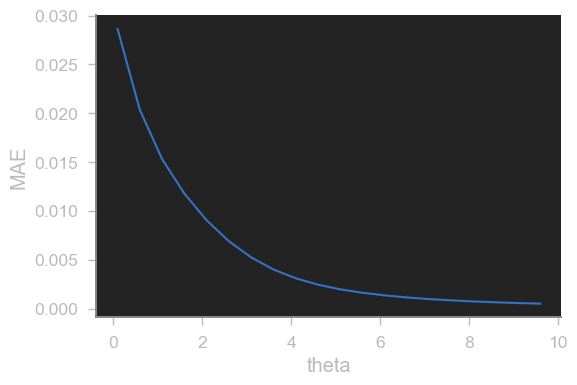

In [73]:
THETAs = np.arange(0.1, 10.1, 0.5)
Tp = 1
MAEs = np.zeros(len(THETAs))
observations = X['C'].iloc[Tp:]

for i, theta in enumerate(THETAs):
    coef = S_map(X, Tp=Tp, theta=theta, target='C')
    # 「予測」は計算結果の回帰係数行列を実際の状態空間ベクトルにかけ合わせて足し算するとできる。（線形モデルなので）
    prediction = (coef * np.hstack((np.ones((len(X) - Tp, 1)), X.iloc[:-Tp, :].values))).sum(axis=1)
    mae = np.abs(prediction - observations).mean()
    MAEs[i] = mae
    
fig, ax = plt.subplots()
ax.plot(THETAs, MAEs)
ax.set_xlabel('theta')
ax.set_ylabel('MAE')
sns.despine()
plt.show()

一応、$\theta = 10$で計算してみる。

In [74]:
theta = 10.0
Tp = 1
observations = X['C'].iloc[Tp:]
coef = S_map(X, Tp=Tp, theta=theta, target='C')

計算結果の回帰係数を理論的な偏微分の値と比較してみる。

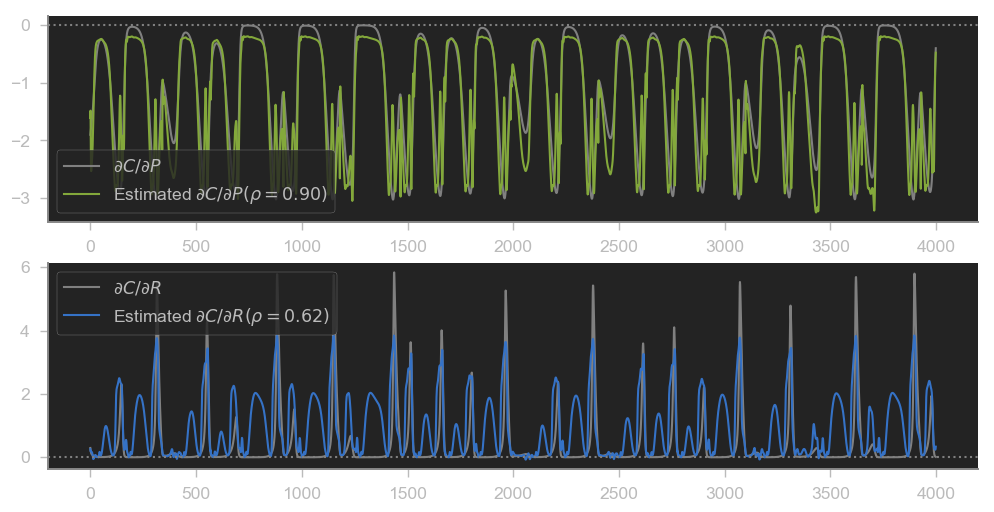

In [75]:
import scipy.stats

# 比較のために（平均は変えずスケールだけ）標準化
delC_delP = scaler.fit_transform(delC_delP.reshape((len(delC_delP),1)))
delC_delR = scaler.fit_transform(delC_delR.reshape((len(delC_delR),1)))

# 回帰係数の結果の行列は4列。それぞれ、バイアス項、P, C, Rとなっている
delC_delP_est = coef[:, 1]
delC_delR_est = coef[:, 3]
delC_delP_est = scaler.fit_transform(delC_delP_est.reshape((len(delC_delP_est),1)))
delC_delR_est = scaler.fit_transform(delC_delR_est.reshape((len(delC_delR_est),1)))

# 理論と推定の間のピアソン相関係数を計算
rho_C_P = scipy.stats.pearsonr(delC_delP[:-Tp].ravel(), delC_delP_est.ravel())[0]
rho_C_R = scipy.stats.pearsonr(delC_delR[:-Tp].ravel(), delC_delR_est.ravel())[0]

fig, axes = plt.subplots(nrows=2, figsize=(12,6))
axes[0].plot(range(length)[:-Tp], delC_delP[:-Tp], color='gray', \
             label='$\partial C / \partial P$')
axes[0].plot(range(length)[:-Tp], delC_delP_est, color='g', \
             label=r'Estimated $\partial C / \partial P (\rho = {:.2f})$'.format(rho_C_P))
axes[1].plot(range(length)[:-Tp], delC_delR[:-Tp], color='gray', \
             label='$\partial C / \partial R$')
axes[1].plot(range(length)[:-Tp], delC_delR_est, color='b', \
             label=r'Estimated $\partial C / \partial R (\rho = {:.2f})$'.format(rho_C_R))
axes[0].axhline(y = 0.0, color='gray', linestyle=':')
axes[1].axhline(y = 0.0, color='gray', linestyle=':')
axes[0].legend(loc='lower left'); axes[1].legend(loc='upper left')
sns.despine()
plt.show()

合ってるような合ってないような...  
少なくとも符号（相互作用の正負）に関してはOK.   
だいたいの形は一致しているけど、とくに$\partial C/ \partial R$推定値のほうで、本来ゼロの部分がところどころボコっとしてるのが気になる。その時間の$\partial C/ \partial P$推定値をみると、こちらも本来ゼロのところで少しマイナス方向に影響を過大に推定してる。もしかしたらどちらもCの増減に効いていないようなタイミングでは、RやPからCへの影響を分離できず適当に帳尻を合わせてしまうのかも。回帰係数出すときになんらかの正則化が必要かもしれない。　　
<br/>  
相互作用時間変動はこんな感じ。S-mapは非線形力学系の未来予測にも使える手法なので、横道だが予測精度に関してもちょっと調べてみる。P, C, Rの３種のデータについて、前半3/4のデータだけ使って、後半1/4の挙動を予測してみる。

In [76]:
from scipy.spatial.distance import cdist

def S_map_predict(lib_df, state_vec, Tp=1, theta=1.0, target='x'):
    target_vec = lib_df[target].values[Tp:]
    values = lib_df.values[:-Tp, :]
    n_points = values.shape[0]
    X = np.hstack((np.ones((n_points, 1)), values))

    dist_vec = cdist([state_vec], values)[0]
    mean_dists = dist_vec.mean()
    weights = np.exp( -1.0 * theta * dist_vec / mean_dists)
    
    b = target_vec * weights
    A = X * weights[:, np.newaxis]
    U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
    inv_sig = np.diag(1./sigma)
    coefficients = Vh.T.dot(inv_sig).dot(U.T).dot(b[:, np.newaxis]).ravel()

    prediction = (np.insert(state_vec, 0, 1.0) * coefficients).sum()
    return prediction

Tp = 1
pred_start = 3000
pred_end = 4000

# ライブラリ（参照点）としてpred_startまでのデータを使う
lib_X = X.iloc[:pred_start, :]

predictions = np.zeros((pred_end - pred_start, 3))
predictions[0, :] = X.iloc[pred_start, :]
for ind in range(1, pred_end - pred_start):
    state = predictions[ind - Tp, :]
    p_pred = S_map_predict(lib_X, state, Tp=Tp, theta=10.0, target='P')
    c_pred = S_map_predict(lib_X, state, Tp=Tp, theta=10.0, target='C')
    r_pred = S_map_predict(lib_X, state, Tp=Tp, theta=10.0, target='R')
    predictions[ind, :] = np.array([p_pred, c_pred, r_pred])    

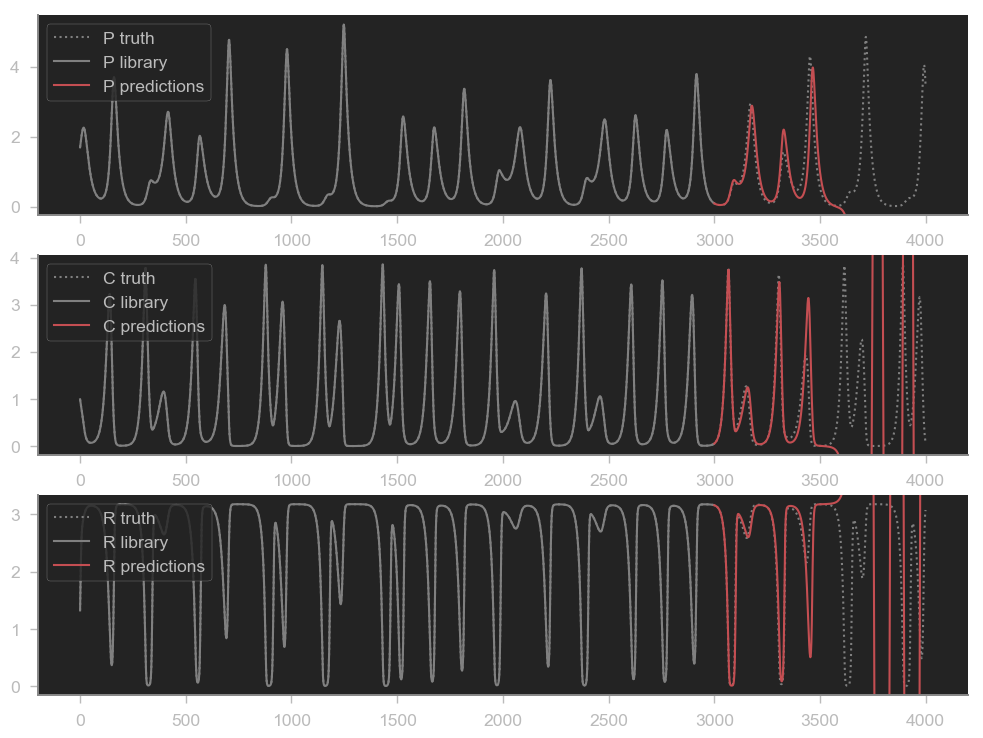

In [77]:
total_length = len(X)
lib_length = len(lib_X)
pred_length = predictions.shape[0]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,9))
for i, sp in enumerate(['P', 'C', 'R']):
    axes[i].plot(range(total_length), X[sp], color='gray', linestyle=':', label=f'{sp} truth')
    axes[i].plot(range(lib_length), lib_X[sp], color='gray', label=f'{sp} library')
    ylim = axes[i].get_ylim()
    axes[i].plot(range(pred_start, pred_start+pred_length), predictions[:, i], color='r', label=f'{sp} predictions')
    axes[i].set_ylim(ylim)
    axes[i].legend(loc='upper left')
sns.despine()
plt.show()

時系列的に近いところはほとんど完璧に予測できてる。けどやっぱり、未来に進むに従ってだんだんと誤差が積み重なってあるポイントで壊滅する。どれだけ先まで予測できるかは力学系とライブラリとして使えるデータの長さに依存すると思うけど、その限界を弁えてればある程度予測にも使えそう。  
<br/>
実際の舞鶴湾データで相互作用の変動を検出してみる。  
実際のデータではまず埋め込みの方法を決めなければならない。ここでは埋め込み次元としてsimplex projectionによる自身の予測精度で決定した次元を使う。  
CCMで有意と検出された（ことにした）相互作用相手の時系列も一緒に埋め込むためにはちょっと特殊な方法を使う。  
たとえば最適な次元数がE、相互作用する相手の数がKだったとき、まず自身の時間遅れをE-K次元で埋め込む（t, t-1, ..., t-(E-k-1)）。その埋め込みにK種の時系列を追加することによって、合計E次元のデータにする。

In [88]:
target =  'Sebastes.inermis'
causes = ['Halichoeres.poecilopterus']
best_edim = int(bestEDim.loc[target, 'E'])
embed = pyEDM.Embed(dataFrame=edm_data, E=best_edim - len(causes), columns=target)
for cause in causes:
    embed[cause] = edm_data[cause].iloc[best_edim - len(causes) - 1:].values
embed.insert(loc=0, column='Time', value=range(len(embed)))
embed

Time  Sebastes.inermis(t-0)  Sebastes.inermis(t-1)  \
0       0              -0.394137              -0.275144   
1       1              -0.453633              -0.394137   
2       2              -0.235480              -0.453633   
3       3              -0.195816              -0.235480   
4       4              -0.473465              -0.195816   
..    ...                    ...                    ...   
258   258              -0.612290              -0.453633   
259   259              -0.632122              -0.612290   
260   260              -0.632122              -0.632122   
261   261              -0.632122              -0.632122   
262   262              -0.632122              -0.632122   

     Sebastes.inermis(t-2)  Sebastes.inermis(t-3)  Sebastes.inermis(t-4)  \
0                -0.473465              -0.532962              -0.513129   
1                -0.275144              -0.473465              -0.532962   
2                -0.394137              -0.275144              -0.473465   
3                -0.453633              -0.394137              -0.275144   
4                -0.235480              -0.453633              -0.394137   
..                     ...                    ...                    ...   
258              -0.552794              -0.532962              -0.394137   
259              -0.453633              -0.552794              -0.532962   
260              -0.612290              -0.453633              -0.552794   
261              -0.632122              -0.612290              -0.453633   
262              -0.632122              -0.632122              -0.612290   

     Sebastes.inermis(t-5)  Sebastes.inermis(t-6)  Sebastes.inermis(t-7)  \
0                 0.319819              -0.513129              -0.275144   
1                -0.513129               0.319819              -0.513129   
2                -0.532962              -0.513129               0.319819   
3                -0.473465              -0.532962              -0.513129   
4                -0.275144              -0.473465              -0.532962   
..                     ...                    ...                    ...   
258              -0.374305              -0.453633              -0.513129   
259              -0.394137              -0.374305              -0.453633   
260              -0.532962              -0.394137              -0.374305   
261              -0.552794              -0.532962              -0.394137   
262              -0.453633              -0.552794              -0.532962   

     Sebastes.inermis(t-8)  ...  Sebastes.inermis(t-14)  \
0                 0.260322  ...                0.121498   
1                -0.275144  ...               -0.453633   
2                -0.513129  ...               -0.552794   
3                 0.319819  ...                0.081833   
4                -0.513129  ...               -0.473465   
..                     ...  ...                     ...   
258              -0.592458  ...                0.855285   
259              -0.513129  ...                4.960529   
260              -0.453633  ...                1.509744   
261              -0.374305  ...                3.393794   
262              -0.394137  ...               -0.532962   

     Sebastes.inermis(t-15)  Sebastes.inermis(t-16)  Sebastes.inermis(t-17)  \
0                  0.101666                0.775957               -0.354473   
1                  0.121498                0.101666                0.775957   
2                 -0.453633                0.121498                0.101666   
3                 -0.552794               -0.453633                0.121498   
4                  0.081833               -0.552794               -0.453633   
..                      ...                     ...                     ...   
258                0.637132               -0.136320                1.291591   
259                0.855285                0.637132               -0.136320   
260                4.960529                0.85528

ここでやろうとしているのは、Halichoeres.poecilopterus → Sebastes.inermisの方向の相互作用の正負の検出。  
$\theta$をこれまで通りの方法で決定する。

<font color="red">2019/12/8以前の版で重大なミスがありました。  
pyEDM.SMap関数は、embedded=True を指定しないと内部で勝手に埋め込みを再計算してしまって、
追加した別の種の時系列を無視してしまうっぽいです。  
なので、与えたデータフレームでそのままSMap計算したい場合はembedded=Trueの指定が必須です。  
以前の版で論文と同じっぽい結果になってたのは偶然です。
</font>

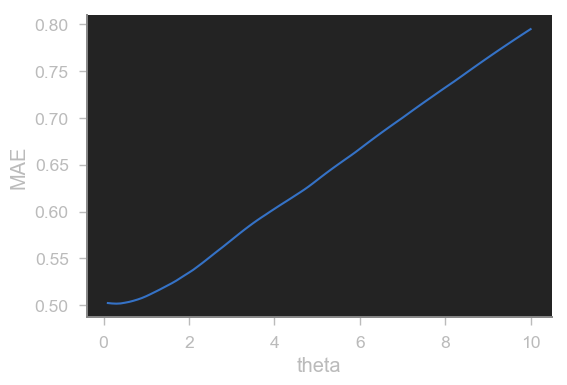

theta value with minimum MAE = 0.30000000000000004


In [89]:
THETAs = np.arange(0.1, 10.1, 0.1)
Tp = 1
MAEs = np.zeros(len(THETAs))
observations = embed[target+'(t-0)'].iloc[Tp:]

for i, theta in enumerate(THETAs):
    results = pyEDM.SMap( dataFrame=embed, \
        lib = "1 200", pred = "1 200", \
        theta = theta, E = len(embed.columns)-1, Tp = 1, embedded=True, \
        verbose = True, showPlot = False, columns = ' '.join(embed.columns[1:]), target=target+'(t-0)')['predictions']
    mae = np.nanmean(np.abs(results['Predictions'] - results['Observations']))
    MAEs[i] = mae

fig, ax = plt.subplots()
ax.plot(THETAs, MAEs)
ax.set_xlabel('theta')
ax.set_ylabel('MAE')
sns.despine()
plt.show()

best_theta = THETAs[np.argmin(MAEs)]
print('theta value with minimum MAE =', best_theta)

~~$\theta$最小がゼロになってしまって、ちょっと微妙なのでここでは恣意的に0.5に設定することにする。~~  
2019/12/8訂正: ちゃんと計算すると0.3になる。

In [92]:
results = pyEDM.SMap( dataFrame=embed, \
     lib = "1 200", pred = "1 200", \
     theta = best_theta, E = len(embed.columns)-1, Tp = 1, embedded=True, \
     verbose = True, showPlot = False, columns = ' '.join(embed.columns[1:]), target=target+'(t-0)') 

`pyEDM`の`SMap`関数は、'predictions'と'coefficients'という2つのキーを持った辞書を返す。  
predictionsのほうは、S-Mapで計算した回帰係数を使って各タイムポイントの予測を出したもの。

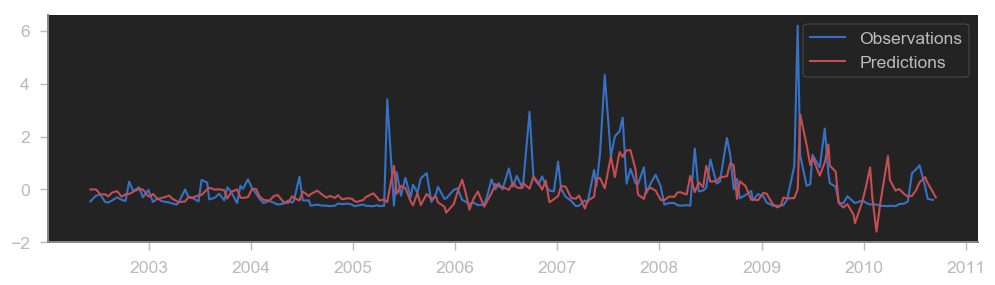

In [93]:
predictions_df = results['predictions']

fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(111)
ax1.plot(edm_data.index[int(predictions_df['Time'].iloc[0]): int(predictions_df['Time'].iloc[-1])], \
        predictions_df['Observations'][1:],  \
        c='b', label='Observations')
ax1.plot(edm_data.index[int(predictions_df['Time'].iloc[0]): int(predictions_df['Time'].iloc[-1])], \
        predictions_df['Predictions'][1:],  \
        c='r', label='Predictions')
ax1.legend()
sns.despine()
plt.show()

ちょっと微妙だけど、一応なんとなくのパターンは予測できている。  
本題は回帰係数のほうで、こっちが相互作用の時間変動。描いてみる。  

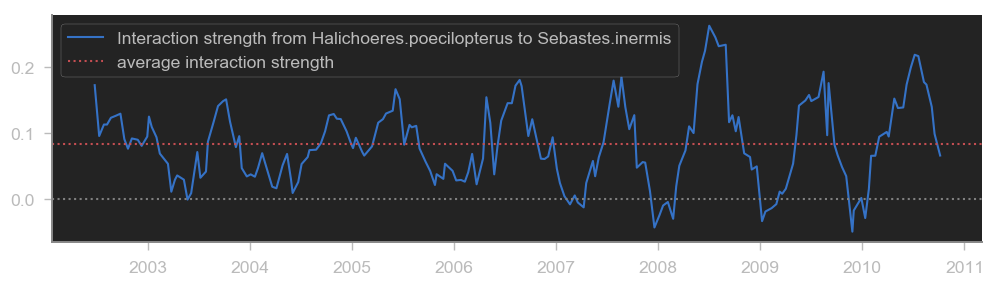

In [94]:
coef = results['coefficients']
interaction_strength = coef[coef.columns[-1]].values

fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(111)
ax1.plot(edm_data.index[int(coef['Time'].iloc[0]): int(coef['Time'].iloc[-1]) + 1], \
        interaction_strength, \
        c='b', label=f'Interaction strength from {causes[0]} to {target}')
ax1.axhline(y=0.0, linestyle=':', color='gray')
ax1.axhline(y=np.nanmean(interaction_strength), linestyle=':', color='r', label='average interaction strength')
ax1.legend()
sns.despine()
plt.show()

~~結果、2007年くらいまではあまり相互作用強度に変化はないが、その後一年周期で上がり下がりするパターンが見られる（春に向かって上昇して秋に向かって落ち込んでいく？）~~  
2019/12/8訂正:2006年以降、夏に増大するパターン。  
  <br/>
冒頭のほうで描いた実際の時系列パターンと照らし合わせるとわかりやすいかも。  
いずれにしても、すべての期間通して常にプラスの値となっていることから、Halichoeres.poecilopterus → Sebastes.inermis の因果関係はプラス（存在量を増やす方向）に働いていることがわかった。 
論文中の解釈によれば、メバル（Sebastes.inermis）は薄明薄暮性でエビを食べていて、一方、ベラ（Halichoeres.poecilopterus）は昼間に活動する雑食の魚らしい。そのためベラの存在が昼間のエビの活動を制限して、メバルの摂食の機会を増やしてるんじゃないか、とのこと。
<br/>
次に、2種それぞれから有意な影響を受けている種について。  
この場合は2種のデータを両方とも加えてS-Mapを計算する。

In [105]:
target = 'Trachurus.japonicus'
causes = ['Rudarius.ercodes', 'Sphyraena.pinguis']
best_edim = int(bestEDim.loc[target, 'E'])

embed = pyEDM.Embed(dataFrame=edm_data, E=best_edim - len(causes), columns=target)
for cause in causes:
    embed[cause] = edm_data[cause].iloc[best_edim - len(causes) - 1:].values
embed.insert(loc=0, column='Time', value=range(len(embed)))
embed

Time  Trachurus.japonicus(t-0)  Trachurus.japonicus(t-1)  \
0       0                 -0.677416                 -0.677416   
1       1                 -0.677416                 -0.677416   
2       2                 -0.677416                 -0.677416   
3       3                 -0.677416                 -0.677416   
4       4                 -0.561246                 -0.677416   
..    ...                       ...                       ...   
259   259                 -0.677416                 -0.677416   
260   260                 -0.677416                 -0.677416   
261   261                 -0.677416                 -0.677416   
262   262                 -0.677416                 -0.677416   
263   263                 -0.677416                 -0.677416   

     Trachurus.japonicus(t-2)  Trachurus.japonicus(t-3)  \
0                   -0.677416                 -0.677416   
1                   -0.677416                 -0.677416   
2                   -0.677416                 -0.677416   
3                   -0.677416                 -0.677416   
4                   -0.677416                 -0.677416   
..                        ...                       ...   
259                 -0.677416                 -0.677416   
260                 -0.677416                 -0.677416   
261                 -0.677416                 -0.677416   
262                 -0.677416                 -0.677416   
263                 -0.677416                 -0.677416   

     Trachurus.japonicus(t-4)  Trachurus.japonicus(t-5)  \
0                   -0.677416                 -0.677416   
1                   -0.677416                 -0.677416   
2                   -0.677416                 -0.677416   
3                   -0.677416                 -0.677416   
4                   -0.677416                 -0.677416   
..                        ...                       ...   
259                 -0.677416                 -0.677416   
260                 -0.677416                 -0.677416   
261                 -0.677416                 -0.677416   
262                 -0.677416                 -0.677416   
263                 -0.677416                 -0.677416   

     Trachurus.japonicus(t-6)  Trachurus.japonicus(t-7)  \
0                   -0.677416                 -0.677416   
1                   -0.677416                 -0.677416   
2                   -0.677416                 -0.677416   
3                   -0.677416                 -0.677416   
4                   -0.677416                 -0.677416   
..                        ...                       ...   
259                  0.871523                  0.871523   
260                 -0.677416                  0.871523   
261                 -0.677416                 -0.677416   
262                 -0.677416                 -0.677416   
263                 -0.677416                 -0.677416   

     Trachurus.japonicus(t-8)  ...  Trachurus.japonicus(t-14)  \
0                   -0.677416  ...                   2.226844   
1                   -0.677416  ...                   2.923866   
2                   -0.677416  ...                   2.184248   
3                   -0.677416  ...                   0.677905   
4                   -0.677416  ...                   0.639182   
..                        ...  ...                        ...   
259                  0.251947  ...                  -0.177883   
260                  0.871523  ...                   2.230716   
261                  0.871523  ...                   2.420461   
262                 -0.677416  ...                   0.484288   
263                 -0.677416  ...                   0.871523   

     Trachurus.japonicus(t-15)  Trachurus.japonicus(t-16)  \
0                    -0.557373                   3.194931   
1                     2.226844                  -0.557373   
2                     2.923866                   2.226844   
3                     2.184248                   2.923866   
4          

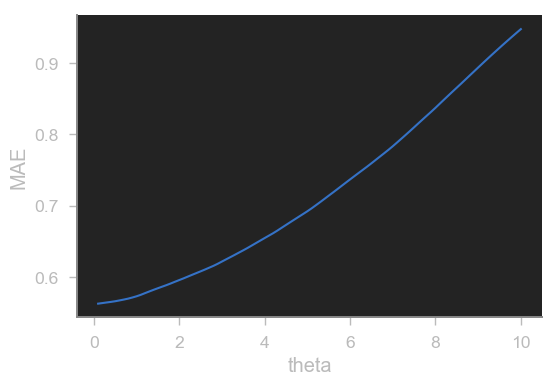

theta value with minimum MAE = 0.1


In [106]:
THETAs = np.arange(0.1, 10.1, 0.1)
Tp = 1
MAEs = np.zeros(len(THETAs))
observations = embed[target+'(t-0)'].iloc[Tp:]

for i, theta in enumerate(THETAs):
    results = pyEDM.SMap( dataFrame=embed, \
        lib = "1 200", pred = "1 200", \
        theta = theta, E = len(embed.columns)-1, Tp = 1, embedded=True, \
        verbose = True, showPlot = False, columns = ' '.join(embed.columns[1:]), target=target+'(t-0)')['predictions']
    mae = np.nanmean(np.abs(results['Predictions'] - results['Observations']))
    MAEs[i] = mae

fig, ax = plt.subplots()
ax.plot(THETAs, MAEs)
ax.set_xlabel('theta')
ax.set_ylabel('MAE')
sns.despine()
plt.show()

best_theta = THETAs[np.argmin(MAEs)]
print('theta value with minimum MAE =', best_theta)

In [107]:
results = pyEDM.SMap( dataFrame=embed, \
     lib = "1 200", pred = "1 200", \
     theta = best_theta, E = len(embed.columns)-1, Tp = 1, embedded=True, \
     verbose = True, showPlot = False, columns = ' '.join(embed.columns[1:]), target=target+'(t-0)') 

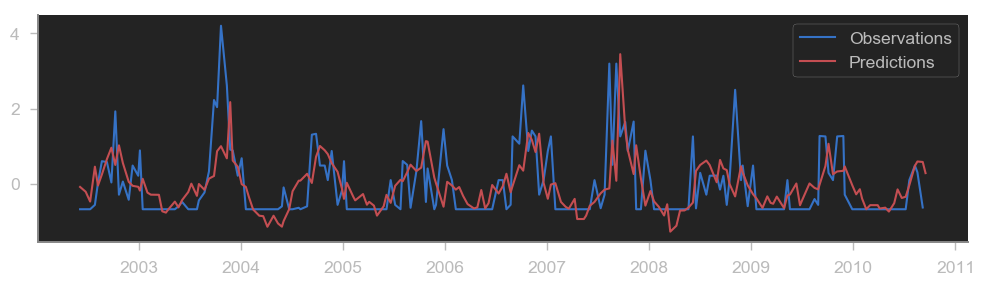

In [108]:
predictions_df = results['predictions']

fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(111)
ax1.plot(edm_data.index[int(predictions_df['Time'].iloc[0]): int(predictions_df['Time'].iloc[-1])], \
        predictions_df['Observations'][1:],  \
        c='b', label='Observations')
ax1.plot(edm_data.index[int(predictions_df['Time'].iloc[0]): int(predictions_df['Time'].iloc[-1])], \
        predictions_df['Predictions'][1:],  \
        c='r', label='Predictions')
ax1.legend()
sns.despine()
plt.show()

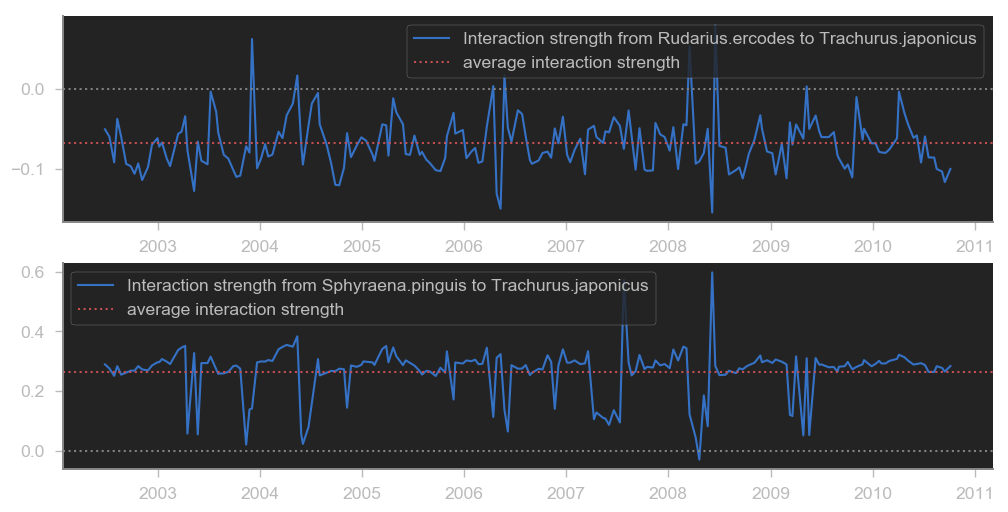

In [109]:
coef = results['coefficients']
interaction_strength_1 = coef[coef.columns[-2]].values
interaction_strength_2 = coef[coef.columns[-1]].values

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
ax1.plot(edm_data.index[int(coef['Time'].iloc[0]): int(coef['Time'].iloc[-1]) + 1], \
        interaction_strength_1, \
        c='b', label=f'Interaction strength from {causes[0]} to {target}')
ax1.axhline(y=0.0, linestyle=':', color='gray')
ax1.axhline(y=np.nanmean(interaction_strength_1), linestyle=':', color='r', label='average interaction strength')
ax2 = fig.add_subplot(212)
ax2.plot(edm_data.index[int(coef['Time'].iloc[0]): int(coef['Time'].iloc[-1]) + 1], \
        interaction_strength_2, \
        c='b', label=f'Interaction strength from {causes[1]} to {target}')
ax2.axhline(y=0.0, linestyle=':', color='gray')
ax2.axhline(y=np.nanmean(interaction_strength_2), linestyle=':', color='r', label='average interaction strength')
ax1.legend(); ax2.legend()
sns.despine()
plt.show()

結果、Rudarius.ercodes → Trachurus.japonicusの影響は全期間で平均をとるとマイナス、Sphyraena.pinguis → Trachurus.japonicusの影響は全期間平均でプラスであることがわかった。  
以下、論文中の解釈。アカカマス（Sphyraena.pinguis）とマアジ（Trachurus.japonicus）はしばしば一緒に観察される。カマスは魚食性だが、マアジはでかくて食えないらしい。マアジはプランクトンや小魚を食べるが、カマスが競合の魚を食ってくれるので、一緒にいるとお互いに都合がいいらしい。  
アミメハギ（Rudarius ercodes）は底生動物やプランクトンを食べる。アミメハギは泳ぎが遅いけど脊椎が強く？て、捕食者はアミメハギ食べるのを躊躇するらしい。つまりマアジと比較して捕食者からの防御に優れているため、マアジにとって負の影響がある。  

以上のようなこと（埋め込み次元や非線形性の検討、CCM、CCMの有意性の検討、S-Mapによる相互作用強度の検出）をすべての魚、すべてのペアに対して計算すると、ようやく論文のFig.1とFig.2ができあがる。論文では後半で、相互作用強度と群集の「安定性」との関わりなど面白い話が続くので、興味がある人は読んでみたら良いと思う。